In [ ]:
# 步骤0: 设置与配置

# 1. 导入核心库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import datasets, transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import time 
from tqdm import tqdm 

# 尝试导入可选库 captum
captum = None
LayerGradCam = None
LayerAttribution = None
captum_available = False
from captum.attr import LayerGradCam, LayerAttribution # 模型可解释性库
print("captum 库及其 LayerGradCam, LayerAttribution 已成功导入。")
import captum
captum_available = True

# 导入库 timm
import timm 
print("timm 库已成功导入。")


# 3. 定义常量和超参数

# 检测设备
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {DEVICE}")

# 数据集根目录
DATA_DIR = './2021_fruits_dataset/'

# 训练集、验证集、测试集路径
TRAIN_DIR = os.path.join(DATA_DIR, '1training')
VAL_DIR = os.path.join(DATA_DIR, '2validation')
TEST_DIR = os.path.join(DATA_DIR, '3test')

# 检查路径是否存在
print(f"\n检查数据集路径:")
for dir_path, dir_name in zip([DATA_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR],
                              ["数据集根目录", "训练集目录", "验证集目录", "测试集目录"]):
    if os.path.exists(dir_path) and os.path.isdir(dir_path):
        print(f"  [信息] {dir_name} '{dir_path}' 存在。")
    else:
        print(f"  [警告/错误] {dir_name} '{dir_path}' 不存在或不是一个目录。请检查路径配置。")

# 图像处理和模型训练相关超参数
BATCH_SIZE = 32  # 批处理大小, 根据 GPU 显存调整
LEARNING_RATE = 1e-4 # 初始学习率
NUM_EPOCHS = 40    # 训练的总轮数
IMAGE_SIZE = 224  # 模型期望的输入图像尺寸
NUM_CLASSES = 5    # 项目需要识别的水果类别数量

# 4. 定义目标类别和映射
target_class_names = ['Apple', 'Grape', 'Pear', 'Banana', 'Cherry']
subfolder_map = {
    'Apple': ["Apple Braeburn", "Apple Crimson Snow", "Apple Golden 1", "Apple Golden 2", "Apple Golden 3", "Apple Granny Smith", "Apple Pink Lady", "Apple Red 1", "Apple Red 2", "Apple Red 3", "Apple Red Delicious", "Apple Red Yellow 1", "Apple Red Yellow 2"],
    'Grape': ["Grape Blue", "Grape Pink", "Grape white", "Grape white 2", "Grape white 3", "Grape white 4"],
    'Pear': ["Pear", "Pear Abate", "Pear Forelle", "Pear Kaiser", "Pear Monster", "Pear Red", "Pear Williams"],
    'Banana': ["Banana", "Banana Lady Finger", "Banana Red"],
    'Cherry': ["Cherry 1", "Cherry 2", "Cherry Rainier", "Cherry Wax Black", "Cherry Wax Red", "Cherry Wax Yellow"]
}
assert all(name in subfolder_map for name in target_class_names), "subfolder_map 字典中缺少某些 target_class_names 的映射, 请检查!"

class_to_idx = {name: i for i, name in enumerate(target_class_names)}
print(f"\n类别到索引的映射 (class_to_idx): {class_to_idx}")
idx_to_class = {i: name for name, i in class_to_idx.items()}
print(f"索引到类别的映射 (idx_to_class): {idx_to_class}")

# 5. 定义 ImageNet 均值和标准差
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
print(f"\nImageNet 均值 (imagenet_mean): {imagenet_mean}")
print(f"ImageNet 标准差 (imagenet_std): {imagenet_std}")

print("\n步骤 0: 设置与配置完成。")

G:\Anaconda3\envs\DL_env2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


captum 库及其 LayerGradCam, LayerAttribution 已成功导入。
timm 库已成功导入。
使用的设备: cuda

检查数据集路径:
  [信息] 数据集根目录 './2021_fruits_dataset/' 存在。
  [信息] 训练集目录 './2021_fruits_dataset/1training' 存在。
  [信息] 验证集目录 './2021_fruits_dataset/2validation' 存在。
  [信息] 测试集目录 './2021_fruits_dataset/3test' 存在。

类别到索引的映射 (class_to_idx): {'Apple': 0, 'Grape': 1, 'Pear': 2, 'Banana': 3, 'Cherry': 4}
索引到类别的映射 (idx_to_class): {0: 'Apple', 1: 'Grape', 2: 'Pear', 3: 'Banana', 4: 'Cherry'}

ImageNet 均值 (imagenet_mean): [0.485, 0.456, 0.406]
ImageNet 标准差 (imagenet_std): [0.229, 0.224, 0.225]

步骤 0: 设置与配置完成。



定义更强大的数据增强变换...
数据变换 (Transforms) 定义完成, 训练集已加入更强增强。

重新实例化数据集以应用新的训练集变换...
尝试创建 训练集(增强后)...

开始初始化 训练集(增强后), 扫描目录: ./2021_fruits_dataset/1training ...


训练集(增强后) 初始化完成, 耗时: 0.01 秒。
  总共找到 12501 个样本。
  各聚合类别样本数:
    - Apple: 4330
    - Grape: 2296
    - Pear: 2426
    - Banana: 1037
    - Cherry: 2412
尝试创建 验证集...

开始初始化 验证集, 扫描目录: ./2021_fruits_dataset/2validation ...


验证集 初始化完成, 耗时: 0.01 秒。
  总共找到 6150 个样本。
  各聚合类别样本数:
    - Apple: 2164
    - Grape: 1148
    - Pear: 1212
    - Banana: 478
    - Cherry: 1148
尝试创建 测试集...

开始初始化 测试集, 扫描目录: ./2021_fruits_dataset/3test ...


测试集 初始化完成, 耗时: 0.01 秒。
  总共找到 6018 个样本。
  各聚合类别样本数:
    - Apple: 2060
    - Grape: 1121
    - Pear: 1212
    - Banana: 477
    - Cherry: 1148

创建 DataLoader 时将使用 0 个 worker。

重新创建 DataLoaders...
正在创建 训练集(增强后) DataLoader...
  训练集(增强后) DataLoader 创建完成。
正在创建 验证集 DataLoader...
  验证集 DataLoader 创建完成。
正在创建 测试集 DataLoader...
  测试集 DataLoader 创建完成。

尝试展示一个训练批次的样本 (应用新增强后)...
  获取到批次大小: 32


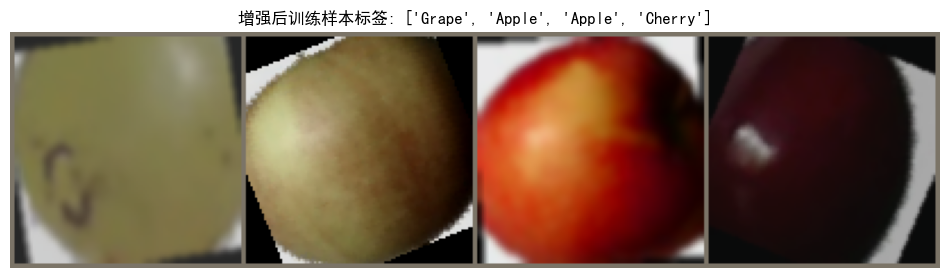

  增强后样本展示完成。

--- 可视化: 类分布 (训练集) ---


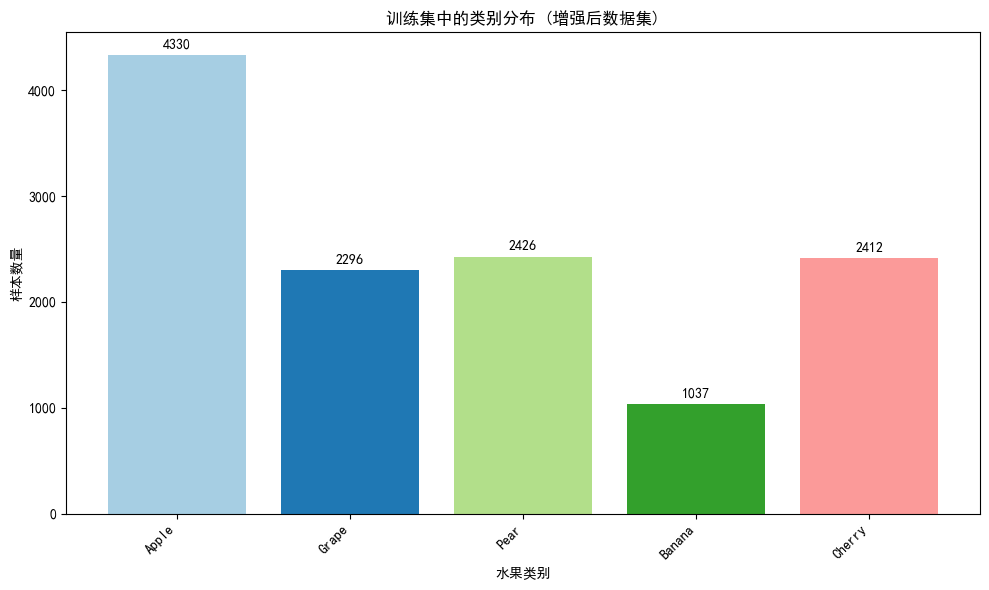


--- 可视化: 新的数据增强示例 ---


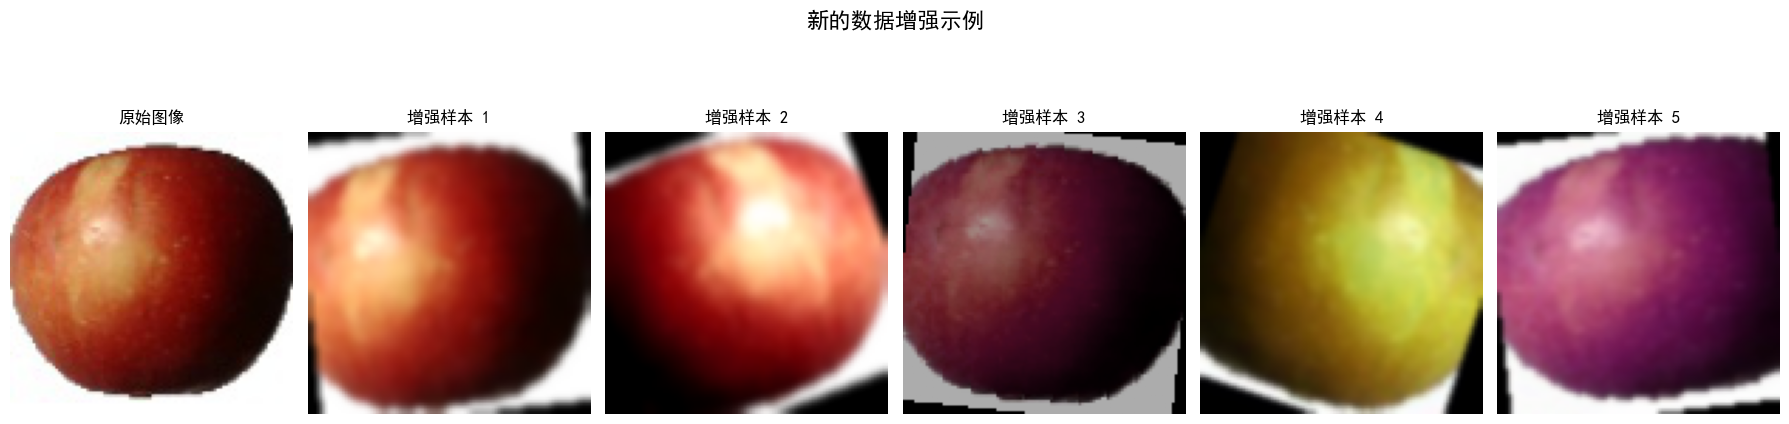


步骤 1: 数据加载与预处理 (已更新数据增强和定义顺序) 完成。


In [ ]:
# 步骤1: 数据加载与预处理 (包含更强的数据增强和修正的定义顺序)

# 1. 导入额外库 (部分已在步骤0导入, 此处确保Dataset, DataLoader等)
from torch.utils.data import Dataset, DataLoader

# 设置 matplotlib 支持中文显示的字体
plt.rcParams['font.sans-serif'] = ['SimHei'] # SimHei是一种常用的支持中文的黑体字
plt.rcParams['axes.unicode_minus'] = False # 解决负号'-'显示为方块的问题

# 2. 实现自定义 Dataset 类 (AggregatedFruitDataset)
class AggregatedFruitDataset(Dataset):
    """
    自定义数据集类, 用于从包含多个子类别的根目录加载水果图像,
    并将它们聚合成指定的主要类别。
    增加了初始化过程的反馈、健壮性以及样本计数。
    """
    def __init__(self, root_dir, subfolder_map, class_to_idx, transform=None, dataset_name="Dataset"):
        self.root_dir = root_dir
        self.subfolder_map = subfolder_map
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.dataset_name = dataset_name
        self.samples = []
        self.class_sample_counts = {name: 0 for name in class_to_idx.keys()}

        print(f"\n开始初始化 {self.dataset_name}, 扫描目录: {self.root_dir} ...")
        start_time_init = time.time()

        if not os.path.isdir(root_dir):
            print(f"  [错误] {self.dataset_name} 的根目录 '{root_dir}' 不存在或不是一个目录。初始化失败。")
            return # 直接返回, samples会为空

        main_class_iterator = tqdm(self.subfolder_map.items(), desc=f"扫描 {self.dataset_name} 主类别", leave=False)
        for main_class, subfolders_list in main_class_iterator:
            if main_class not in self.class_to_idx:
                print(f"  [警告] ({self.dataset_name}): 主类别 '{main_class}' 在 subfolder_map 中, 但不在 class_to_idx 中, 将被忽略。")
                continue

            aggregated_label = self.class_to_idx[main_class]
            samples_found_for_this_main_class = 0
            for subfolder_name in subfolders_list:
                subfolder_path = os.path.join(self.root_dir, subfolder_name)
                if not os.path.isdir(subfolder_path):
                    # print(f"  [调试信息] ({self.dataset_name}): 子目录 '{subfolder_path}' 不存在或不是目录, 已跳过。")
                    continue
                
                # 直接列出文件，如果os.scandir失败，程序会因移除了try-except而崩溃
                for entry in os.scandir(subfolder_path):
                    if entry.is_file() and entry.name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                        image_path = entry.path
                        self.samples.append((image_path, aggregated_label))
                        samples_found_for_this_main_class += 1
            
            self.class_sample_counts[main_class] += samples_found_for_this_main_class

        end_time_init = time.time()
        print(f"{self.dataset_name} 初始化完成, 耗时: {end_time_init - start_time_init:.2f} 秒。")
        print(f"  总共找到 {len(self.samples)} 个样本。")
        print(f"  各聚合类别样本数:")
        for name, count in self.class_sample_counts.items():
            print(f"    - {name}: {count}")

        if not self.samples:
            print(f"  [严重警告] ({self.dataset_name}): 未找到任何符合条件的图片样本。")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        return image, label

# 3. 定义数据变换 (Transforms)
print("\n定义更强大的数据增强变换...")
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.6, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.15),
    transforms.RandomAutocontrast(p=0.3),
    transforms.RandomEqualize(p=0.2),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # 使用元组以明确 Resize
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
print("数据变换 (Transforms) 定义完成, 训练集已加入更强增强。")

# 4. 定义实例化数据集对象的辅助函数 (`create_dataset`)
def create_dataset(root_dir, subfolder_map, class_to_idx, transform, dataset_name):
    """创建 AggregatedFruitDataset 实例"""
    print(f"尝试创建 {dataset_name}...")

    dataset = AggregatedFruitDataset(root_dir=root_dir,
                                     subfolder_map=subfolder_map,
                                     class_to_idx=class_to_idx,
                                     transform=transform,
                                     dataset_name=dataset_name)

    if not hasattr(dataset, 'samples') or dataset.samples is None or \
       (len(dataset.samples) == 0 and os.path.isdir(root_dir)): 
        if os.path.isdir(root_dir) and (not hasattr(dataset, 'samples') or len(dataset.samples) == 0):
             print(f"  [严重警告] {dataset_name} 创建成功但未包含任何样本, 或者初始化失败。后续步骤可能失败。")
    return dataset

# 实例化所有数据集
print("\n重新实例化数据集以应用新的训练集变换...")
train_dataset = create_dataset(TRAIN_DIR, subfolder_map, class_to_idx, train_transforms, "训练集(增强后)")
val_dataset = create_dataset(VAL_DIR, subfolder_map, class_to_idx, val_test_transforms, "验证集")
test_dataset = create_dataset(TEST_DIR, subfolder_map, class_to_idx, val_test_transforms, "测试集")


# 5. 定义创建数据加载器相关的辅助函数

num_workers = 4 if os.cpu_count() is not None and os.cpu_count() > 4 else 0
if os.name == 'nt': num_workers = 0 

print(f"\n创建 DataLoader 时将使用 {num_workers} 个 worker。")

# 自定义 Collate 函数 (用于跳过Dataset中返回None的样本)
def collate_fn_skip_none(batch):
    batch = list(filter(lambda x: x is not None and x[0] is not None, batch))
    if not batch: # 如果所有样本都被过滤掉了
        return torch.tensor([]), torch.tensor([])
    return torch.utils.data.dataloader.default_collate(batch)

# 创建 DataLoader 的辅助函数
def create_dataloader(dataset, batch_size, shuffle, num_workers, dataset_name):
    if dataset is not None and hasattr(dataset, 'samples') and len(dataset.samples) > 0:
        print(f"正在创建 {dataset_name} DataLoader...")
        loader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=num_workers,
                            pin_memory=True if DEVICE.type == 'cuda' else False,
                            collate_fn=collate_fn_skip_none) # 使用自定义的collate_fn
        print(f"  {dataset_name} DataLoader 创建完成。")
        return loader
    else:
        print(f"  [错误] 无法创建 {dataset_name} DataLoader, 数据集无效或为空。")
        return None

# 创建所有 DataLoaders
print("\n重新创建 DataLoaders...")
train_loader = create_dataloader(train_dataset, BATCH_SIZE, True, num_workers, "训练集(增强后)")
val_loader = create_dataloader(val_dataset, BATCH_SIZE, False, num_workers, "验证集")
test_loader = create_dataloader(test_dataset, BATCH_SIZE, False, num_workers, "测试集")

# 6. 定义图像显示函数 (imshow)
def imshow(inp, title=None):
    """显示 torch.Tensor 类型的图像 (反归一化并转换)。"""
    if isinstance(inp, torch.Tensor):
        inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array(imagenet_mean)
    std = np.array(imagenet_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        if isinstance(title, list): # 处理网格图像的标题列表
            title = ", ".join(map(str, title))
        plt.title(title)
    plt.axis('off') # 显示图像样本时关闭坐标轴

# 7. 展示一个批次的数据进行验证
print("\n尝试展示一个训练批次的样本 (应用新增强后)...")
if train_loader and hasattr(train_loader, 'dataset') and train_loader.dataset is not None and len(train_loader.dataset) > 0:
    # 移除了try-except StopIteration 和其他 Exception
    inputs, classes = next(iter(train_loader)) # 如果 loader 为空会直接报错
    if inputs.numel() == 0:
        print("  获取到的第一个批次为空。无法展示。")
    else:
        print(f"  获取到批次大小: {inputs.shape[0]}")
        grid_size = min(inputs.shape[0], 4) # 最多显示4张图片
        out = torchvision.utils.make_grid(inputs[:grid_size])
        class_names_display = [idx_to_class.get(x.item(), "未知") for x in classes[:grid_size]]
        
        plt.figure(figsize=(12, 7))
        imshow(out, title=f"增强后训练样本标签: {class_names_display}")
        plt.show()
        print("  增强后样本展示完成。")
else:
    print("  未执行样本展示, train_loader 无效或其数据集为空。")

# 8. 可视化补充
# 8.1 类分布图
print("\n--- 可视化: 类分布 (训练集) ---")
if train_dataset is not None and hasattr(train_dataset, 'class_sample_counts') and train_dataset.class_sample_counts:
    class_names_dist = list(train_dataset.class_sample_counts.keys())
    sample_counts_dist = list(train_dataset.class_sample_counts.values())

    if not class_names_dist or not sample_counts_dist : # 检查列表是否为空
        print("  类别名或样本数列表为空, 无法绘制类分布图。")
    else:
        plt.figure(figsize=(10, 6))
        bars = plt.bar(class_names_dist, sample_counts_dist, color=plt.cm.Paired(np.arange(len(class_names_dist))))
        plt.xlabel("水果类别")
        plt.ylabel("样本数量")
        plt.title("训练集中的类别分布 (增强后数据集)")
        plt.xticks(rotation=45, ha="right")
        max_count_for_text = max(sample_counts_dist) if sample_counts_dist else 1 # 防止max()在空列表上出错
        for bar_item in bars:
            yval = bar_item.get_height()
            plt.text(bar_item.get_x() + bar_item.get_width()/2.0, yval + 0.01*max_count_for_text, int(yval), ha='center', va='bottom')
        plt.tight_layout()
        plt.show()
else:
    print("  跳过类别分布图: train_dataset 或其 class_sample_counts 不可用或为空。")

# 8.2 数据增强示例
print("\n--- 可视化: 新的数据增强示例 ---")
# 定义逆标准化函数 
def denormalize_image_for_augmentation_vis(tensor, mean, std): 
    tensor_vis = tensor.clone().cpu()
    if tensor_vis.ndim == 4 and tensor_vis.shape[0] == 1: tensor_vis = tensor_vis.squeeze(0) # 移除批次维度
    for t_channel, m, s in zip(tensor_vis, mean, std): # 对每个通道操作
        t_channel.mul_(s).add_(m) # 逆标准化: (tensor * std) + mean
    tensor_vis = tensor_vis.permute(1, 2, 0) # CHW -> HWC
    return torch.clamp(tensor_vis, 0, 1).numpy() # 裁剪到 [0,1] 范围并转为numpy

if train_dataset is not None and hasattr(train_dataset, 'samples') and len(train_dataset.samples) > 0 and train_transforms is not None:
    num_augmentation_examples = 5
    sample_img_path_aug, _ = train_dataset.samples[0] 
    original_pil_img_aug = Image.open(sample_img_path_aug).convert('RGB')

    plt.figure(figsize=(18, 5))
    plt.subplot(1, num_augmentation_examples + 1, 1)
    plt.imshow(original_pil_img_aug)
    plt.title("原始图像")
    plt.axis('off')

    for i in range(num_augmentation_examples):
        augmented_tensor = train_transforms(original_pil_img_aug)
        augmented_img_np = denormalize_image_for_augmentation_vis(augmented_tensor, imagenet_mean, imagenet_std)
        plt.subplot(1, num_augmentation_examples + 1, i + 2)
        plt.imshow(augmented_img_np)
        plt.title(f"增强样本 {i+1}")
        plt.axis('off')
    
    plt.suptitle("新的数据增强示例", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 调整布局以防止标题重叠
    plt.show()
else:
    print("  跳过新的数据增强可视化: train_dataset, 其样本, 或 train_transforms 不可用。")

print("\n步骤 1: 数据加载与预处理 (已更新数据增强和定义顺序) 完成。")


In [ ]:
# 步骤2: 定义模型架构 (实例化 PureCNNModel 使用 resnet34)

# 2. 定义 PureCNNModel 类 
class PureCNNModel(nn.Module):
    def __init__(self, num_classes, cnn_backbone_name='resnet34', dropout_classifier_head=0.3):
        super(PureCNNModel, self).__init__()
        print(f"\n开始初始化 PureCNNModel (CNN Backbone: {cnn_backbone_name}, 分类头 Dropout: {dropout_classifier_head})...")
        self.num_classes = num_classes
        self.cnn_backbone_name = cnn_backbone_name
        self.cnn_out_channels = None

        if timm is None:
            print("  [错误] timm 库未导入, 无法创建基于timm的模型。") 
            raise ImportError("timm 库未导入,无法创建模型")


        # 加载预训练的 CNN backbone (只取特征提取部分)
        self.cnn_backbone = timm.create_model(
            cnn_backbone_name,
            pretrained=True,
            features_only=True # 只获取特征图输出
        )
        print(f"  成功加载 CNN backbone: {self.cnn_backbone_name} (使用 features_only=True)")

        # 动态获取 CNN backbone 输出的通道数
        if hasattr(self.cnn_backbone, 'feature_info'):
            feature_info_obj = self.cnn_backbone.feature_info
            
            processed_feature_stages = []
            if hasattr(feature_info_obj, 'get_dicts'): 
                feature_dicts = feature_info_obj.get_dicts()
                # print(f"  DEBUG: feature_info.get_dicts() output: {feature_dicts}")
                for i, info_dict in enumerate(feature_dicts):
                    if isinstance(info_dict, dict) and 'num_chs' in info_dict and 'reduction' in info_dict and 'module' in info_dict:
                        processed_feature_stages.append({
                            'module': info_dict['module'],
                            'reduction': info_dict['reduction'],
                            'channels': info_dict['num_chs'] 
                        })
                       
            elif isinstance(feature_info_obj, list): 

                for i, info_tuple in enumerate(feature_info_obj):
 
                    if hasattr(info_tuple, 'channels') and hasattr(info_tuple, 'reduction') and hasattr(info_tuple, 'module'):
                        processed_feature_stages.append({
                            'module': info_tuple.module,
                            'reduction': info_tuple.reduction,
                            'channels': info_tuple.channels
                        })
            
            if processed_feature_stages:
                self.cnn_out_channels = processed_feature_stages[-1]['channels']
                print(f"  PureCNN: 从 feature_info (最后一个有效阶段) 获取到通道数: {self.cnn_out_channels}")
            else:
                print("  DEBUG: 未能从 feature_info 解析出任何有效的特征阶段。")
        else:
            print("  DEBUG: Backbone does not have feature_info attribute.")

        # 如果未能从 feature_info 获取通道数, 使用 dummy pass 探测
        if self.cnn_out_channels is None:
            print("  PureCNN: 未能从 feature_info 获取通道数, 正在通过 dummy pass 探测 CNN backbone 输出维度...")
            with torch.no_grad():
                _dummy_device_cnn = DEVICE
                # 尝试获取模型参数所在的设备，如果模型没有参数则保持DEVICE
                
                dummy_input_cnn = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(_dummy_device_cnn)
                self.cnn_backbone.to(_dummy_device_cnn) # 确保backbone在正确的设备上
                cnn_output_feature_list = self.cnn_backbone(dummy_input_cnn)
                
                if not cnn_output_feature_list:
                    print("  [错误] Dummy pass 探测 CNN 输出维度时, backbone (features_only=True) 返回了空列表。")
                
                cnn_output_features_cnn = cnn_output_feature_list[-1] # 取最后一个stage的特征图
                self.cnn_out_channels = cnn_output_features_cnn.shape[1]
                print(f"  PureCNN: CNN Backbone (最后一个特征图) 输出通道数: {self.cnn_out_channels}, 特征图尺寸: {cnn_output_features_cnn.shape[2:]}")
        
        # 如果以上方法都失败，尝试从完整模型加载num_features作为最后的fallback
        if self.cnn_out_channels is None:
            print("  PureCNN: 主探测和 feature_info 均失败, 尝试从完整模型的 num_features 回退...")
            temp_full_model = timm.create_model(cnn_backbone_name, pretrained=False) # 不需要预训练权重，只为结构
            if hasattr(temp_full_model, 'get_classifier') and hasattr(temp_full_model.get_classifier(), 'in_features'): # 很多timm模型有这个
                self.cnn_out_channels = temp_full_model.get_classifier().in_features
                print(f"  PureCNN: [Fallback] 使用 cnn_model_base.get_classifier().in_features: {self.cnn_out_channels}")
            elif hasattr(temp_full_model, 'num_features'): # 通用一些的timm属性
                 self.cnn_out_channels = temp_full_model.num_features
                 print(f"  PureCNN: [Fallback] 使用 cnn_model_base.num_features: {self.cnn_out_channels}")
            else:
                 del temp_full_model
                 # 程序会因 self.cnn_out_channels is None 而在后续崩溃
                 print(f"  PureCNN: [Fallback Error] 无法从 num_features 或 get_classifier().in_features 回退获取通道数。")

        if self.cnn_out_channels is None:
            # raise RuntimeError("PureCNN: 最终未能确定 cnn_out_channels.")
            # 程序会在此处因后续的 nn.Linear(None, num_classes) 而崩溃
            print("  [严重错误] PureCNN: 最终未能确定 cnn_out_channels。模型初始化可能不完整。")


        # 定义分类头
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # 全局平均池化
        self.flatten = nn.Flatten() # 展平
        self.head_dropout = nn.Dropout(dropout_classifier_head) # Dropout层
        if self.cnn_out_channels is not None: # 仅当通道数确定时创建分类器
            self.classifier = nn.Linear(self.cnn_out_channels, num_classes) # 线性分类层
            print(f"  PureCNN: 分类头前 Dropout 层创建, p={dropout_classifier_head}")
            print(f"  PureCNN: 分类头创建: Linear({self.cnn_out_channels}, {num_classes})")
        else:
            # 这种情况不应该发生，如果发生了，模型将无法正确构建
            self.classifier = None 
            print("  [严重错误] PureCNN: cnn_out_channels 未确定, 无法创建分类头。")


        print("PureCNNModel 初始化完成。")

    def forward(self, x):
        feature_map_list = self.cnn_backbone(x) # 获取特征图列表
        if not feature_map_list:
            print(f"  [错误] Backbone {self.cnn_backbone_name} 在前向传播中返回了空特征列表。")

        features = feature_map_list[-1] # 通常取最后一个 (最高层) 特征图
        
        x = self.global_avg_pool(features)
        x = self.flatten(x)
        x = self.head_dropout(x)
        if self.classifier is None:
             print("  [错误] 分类器未初始化，无法完成前向传播。") # 这会导致后续操作失败
        logits = self.classifier(x)
        return logits

# --- 3. 模型选择和实例化 ---
print("="*30)
print("选择并实例化模型...")

CHOSEN_MODEL_TYPE = 'cnn' # 只处理CNN模型
cnn_backbone_choice = 'resnet34'
dropout_head_config_cnn = 0.5 # dropout率

print(f"当前选择的模型类型 (CHOSEN_MODEL_TYPE): '{CHOSEN_MODEL_TYPE}'")
print(f"选择的 CNN Backbone: '{cnn_backbone_choice}'")
print(f"PureCNNModel 分类头 Dropout 率配置: {dropout_head_config_cnn}")

model = None
if CHOSEN_MODEL_TYPE == 'cnn':
    if timm is None:

        print("  [错误] timm 库未加载, 无法实例化 PureCNNModel。")

    print(f"实例化 PureCNNModel (Backbone: {cnn_backbone_choice}, 分类头 Dropout: {dropout_head_config_cnn})...")
    model = PureCNNModel(
        num_classes=NUM_CLASSES,
        cnn_backbone_name=cnn_backbone_choice,
        dropout_classifier_head=dropout_head_config_cnn
    ).to(DEVICE)
else:
    print(f"  [错误] 当前 CHOSEN_MODEL_TYPE ('{CHOSEN_MODEL_TYPE}') 不支持。")

# 确保模型已成功实例化
if model is not None:
    print(f"\n模型 '{CHOSEN_MODEL_TYPE}' (Backbone: {getattr(model, 'cnn_backbone_name', 'N/A')}) 实例化完成 (已配置 Dropout) 并移至: {DEVICE}")
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"模型 '{CHOSEN_MODEL_TYPE}' 可训练参数总量: {num_params / 1e6:.2f} M")
else:
    # 程序会因后续操作中 model is None 而崩溃
    print(f"  [错误] 模型实例化 ('{CHOSEN_MODEL_TYPE}') 失败。")

print("="*30)


# --- 4.  冻结 CNN Backbone 参数 --- 
freeze_cnn_backbone = False # 默认为False, 即不冻结
if model is not None and hasattr(model, 'cnn_backbone') and freeze_cnn_backbone:
    print("\n正在冻结 CNN Backbone 的参数...")
    for param in model.cnn_backbone.parameters():
        param.requires_grad = False
    # 验证冻结状态 (可选)
    # for name, param in model.cnn_backbone.named_parameters():
    #     if not param.requires_grad:
    #         print(f"  参数 {name} 已冻结。")
    print("CNN Backbone 参数已冻结。")
elif model is not None:
    print("\nCNN Backbone 参数未冻结 (默认行为)。")


# --- 5.  模型单次前向传播测试 ---
if model is not None and 'train_loader' in locals() and train_loader is not None and \
   hasattr(train_loader, 'dataset') and train_loader.dataset is not None and len(train_loader.dataset) > 0:
    print("\n正在进行模型单次前向传播测试...")
    model_eval_state_before_test = model.training # 保存模型原始的训练/评估状态
    
    test_inputs_tuple = next(iter(train_loader)) # 如果loader为空会报错
    test_inputs = test_inputs_tuple[0]

    if test_inputs.numel() > 0:
        test_inputs = test_inputs.to(DEVICE)
        model.eval() # 设置为评估模式
        with torch.no_grad(): # 关闭梯度计算
            outputs_test = model(test_inputs)
        print(f"  模型输入形状: {test_inputs.shape}")
        print(f"  模型输出形状 (logits): {outputs_test.shape}")
        assert outputs_test.shape[0] == test_inputs.shape[0], "输出批次大小与输入不符!"
        assert outputs_test.shape[1] == NUM_CLASSES, f"输出类别数量与 NUM_CLASSES ({NUM_CLASSES}) 不符!"
        print("  模型单次前向传播测试成功。")
    else:
        print("  测试批次为空, 跳过前向传播测试。")
    
    # 恢复模型原始状态
    if model_eval_state_before_test:
        model.train()
    else:
        model.eval()
elif model is None:
    print("\n未执行模型前向传播测试 (模型未成功实例化)。")
elif 'train_loader' not in locals() or train_loader is None:
    print("\n未执行模型前向传播测试 (train_loader 未定义或为 None)。")
else: # train_loader.dataset 无效或为空
    print("\n未执行模型前向传播测试 (train_loader 数据集无效或为空)。")

print(f"\n步骤 2: 定义模型架构完成 (当前已实例化 {CHOSEN_MODEL_TYPE if 'CHOSEN_MODEL_TYPE' in locals() else '未知'} 模型, 使用 {cnn_backbone_choice if 'cnn_backbone_choice' in locals() else '未知'} 主干)。")


选择并实例化模型...
当前选择的模型类型 (CHOSEN_MODEL_TYPE): 'cnn'
选择的 CNN Backbone: 'resnet34'
PureCNNModel 分类头 Dropout 率配置: 0.5
实例化 PureCNNModel (Backbone: resnet34, 分类头 Dropout: 0.5)...

开始初始化 PureCNNModel (CNN Backbone: resnet34, 分类头 Dropout: 0.5)...
  成功加载 CNN backbone: resnet34 (使用 features_only=True)
  PureCNN: 从 feature_info (最后一个有效阶段) 获取到通道数: 512
  PureCNN: 分类头前 Dropout 层创建, p=0.5
  PureCNN: 分类头创建: Linear(512, 5)
PureCNNModel 初始化完成。

模型 'cnn' (Backbone: resnet34) 实例化完成 (已配置 Dropout) 并移至: cuda
模型 'cnn' 可训练参数总量: 21.29 M

CNN Backbone 参数未冻结 (默认行为)。

正在进行模型单次前向传播测试...
  模型输入形状: torch.Size([32, 3, 100, 100])
  模型输出形状 (logits): torch.Size([32, 5])
  模型单次前向传播测试成功。

步骤 2: 定义模型架构完成 (当前已实例化 cnn 模型, 使用 resnet34 主干)。


In [ ]:
# 步骤3: 定义损失函数和优化器 (针对PureCNNModel)

from torch.optim import lr_scheduler # 导入 lr_scheduler

# 初始化变量, 以防前置检查失败时变量未定义
criterion = None
optimizer = None
scheduler = None # 确保 scheduler 被初始化

# 1. 前置检查: 确保 model 对象存在且有效
if 'model' not in locals() or model is None or not isinstance(model, PureCNNModel):
    print(f"  [错误] 'model' 对象不存在、为 None 或不是预期的 PureCNNModel 类型。无法定义损失函数和优化器。")
    if 'model' in locals(): print(f"  当前 model 类型: {type(model)}")
    # 程序后续会因为 criterion/optimizer 为 None 而崩溃
else:
    print(f"PureCNNModel ('{model.cnn_backbone_name}' backbone) 已找到, 开始定义损失函数和优化器...")

    # 2. 损失函数
    criterion = nn.CrossEntropyLoss()
    print(f"  损失函数定义: {type(criterion).__name__}")

    # 3. 优化器
    params_to_optimize = [p for p in model.parameters() if p.requires_grad]
    num_trainable_params_for_optimizer = sum(p.numel() for p in params_to_optimize)

    if num_trainable_params_for_optimizer > 0:
        # PureCNNModel optimizer now matches the Transformer file (AdamW with just LEARNING_RATE)
        # LEARNING_RATE is 1e-4, defined in Step 0
        print(f"  传递给优化器的可训练参数总量: {num_trainable_params_for_optimizer / 1e6:.2f} M")
        
        optimizer = optim.AdamW(params_to_optimize, lr=LEARNING_RATE)
        print(f"  优化器定义: {type(optimizer).__name__} (学习率: {LEARNING_RATE})")
    else:
        print("  [警告] PureCNNModel 中没有需要训练的参数, 优化器未创建。")
        optimizer = None # 明确设为None

    # 4.  学习率调度器 (Using StepLR from Transformer file)
    use_scheduler_cnn = True # 设置为 True 以启用调度器
    if use_scheduler_cnn and optimizer is not None:
        print("  为 PureCNNModel 配置学习率调度器 (StepLR from Transformer file)...")
        # Parameters from Transformer file's StepLR
        scheduler_step_size_cnn = 7 # Adapted name for consistency within this file, value from Transformer
        scheduler_gamma_cnn = 0.1   # Adapted name, value from Transformer
        
        scheduler = lr_scheduler.StepLR(optimizer,
                                        step_size=scheduler_step_size_cnn,
                                        gamma=scheduler_gamma_cnn)
        print(f"  学习率调度器定义: {type(scheduler).__name__} (step_size={scheduler_step_size_cnn}, gamma={scheduler_gamma_cnn})")
    elif use_scheduler_cnn and optimizer is None:
        print("  [信息] 计划为 PureCNNModel 使用学习率调度器, 但优化器未成功创建。")
        scheduler = None # 明确设为None
    else: # use_scheduler_cnn is False
        scheduler = None # 明确设为None
        print("  未为 PureCNNModel 定义学习率调度器 (use_scheduler_cnn 设置为 False)。")

print(f"\n步骤 3: 为 PureCNNModel ({model.cnn_backbone_name if model and hasattr(model, 'cnn_backbone_name') else 'N/A'}) 定义损失函数和优化器完成。")

PureCNNModel ('resnet34' backbone) 已找到, 开始定义损失函数和优化器...
  损失函数定义: CrossEntropyLoss
  传递给优化器的可训练参数总量: 21.29 M
  优化器定义: AdamW (学习率: 0.0001)
  为 PureCNNModel 配置学习率调度器 (StepLR from Transformer file)...
  学习率调度器定义: StepLR (step_size=7, gamma=0.1)

步骤 3: 为 PureCNNModel (resnet34) 定义损失函数和优化器完成。


--- 开始步骤 4 前置检查 (PureCNNModel 训练, 带早停逻辑) ---

所有 PureCNNModel (resnet34) 训练组件准备就绪, 开始初始化训练过程 (带早停)...
PureCNNModel (resnet34) 训练开始时间: 2025-05-17 10:33:37
  最佳模型将保存到: best_model_cnn_resnet34.pth
  训练历史将保存到: training_history_cnn_resnet34.json

Epoch 1/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.4644 准确率: 0.8269
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.1284 准确率: 0.9478
      *** 新的最佳 PureCNNModel (resnet34) (基于准确率: 0.9478) 已保存到 'best_model_cnn_resnet34.pth' ***
      验证损失改善至 0.1284, 重置早停计数器。
  Epoch 1 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.84秒
  学习率调度器更新, 当前学习率: 1.000e-04

Epoch 2/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.1355 准确率: 0.9547
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0636 准确率: 0.9793
      *** 新的最佳 PureCNNModel (resnet34) (基于准确率: 0.9793) 已保存到 'best_model_cnn_resnet34.pth' ***
      验证损失改善至 0.0636, 重置早停计数器。
  Epoch 2 (PureCNNModel - resnet34) 完成, 耗时: 0分 48.99秒
  学习率调度器更新, 当前学习率: 1.000e-04

Epoch 3/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0999 准确率: 0.9670
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.1243 准确率: 0.9462
      验证损失未显著改善 (1/7) (当前: 0.1243, 最佳: 0.0636)
  Epoch 3 (PureCNNModel - resnet34) 完成, 耗时: 0分 48.93秒
  学习率调度器更新, 当前学习率: 1.000e-04

Epoch 4/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0607 准确率: 0.9809
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0702 准确率: 0.9774
      验证损失未显著改善 (2/7) (当前: 0.0702, 最佳: 0.0636)
  Epoch 4 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.02秒
  学习率调度器更新, 当前学习率: 1.000e-04

Epoch 5/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0566 准确率: 0.9826
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0750 准确率: 0.9657
      验证损失未显著改善 (3/7) (当前: 0.0750, 最佳: 0.0636)
  Epoch 5 (PureCNNModel - resnet34) 完成, 耗时: 0分 48.86秒
  学习率调度器更新, 当前学习率: 1.000e-04

Epoch 6/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0452 准确率: 0.9856
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0639 准确率: 0.9743
      验证损失未显著改善 (4/7) (当前: 0.0639, 最佳: 0.0636)
  Epoch 6 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.53秒
  学习率调度器更新, 当前学习率: 1.000e-04

Epoch 7/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0434 准确率: 0.9866
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0673 准确率: 0.9795
      *** 新的最佳 PureCNNModel (resnet34) (基于准确率: 0.9795) 已保存到 'best_model_cnn_resnet34.pth' ***
      验证损失未显著改善 (5/7) (当前: 0.0673, 最佳: 0.0636)
  Epoch 7 (PureCNNModel - resnet34) 完成, 耗时: 0分 50.20秒
  学习率调度器更新, 当前学习率: 1.000e-05

Epoch 8/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0236 准确率: 0.9924
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0577 准确率: 0.9826
      *** 新的最佳 PureCNNModel (resnet34) (基于准确率: 0.9826) 已保存到 'best_model_cnn_resnet34.pth' ***
      验证损失改善至 0.0577, 重置早停计数器。
  Epoch 8 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.18秒
  学习率调度器更新, 当前学习率: 1.000e-05

Epoch 9/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0143 准确率: 0.9960
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0625 准确率: 0.9834
      *** 新的最佳 PureCNNModel (resnet34) (基于准确率: 0.9834) 已保存到 'best_model_cnn_resnet34.pth' ***
      验证损失未显著改善 (1/7) (当前: 0.0625, 最佳: 0.0577)
  Epoch 9 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.21秒
  学习率调度器更新, 当前学习率: 1.000e-05

Epoch 10/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0149 准确率: 0.9960
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0573 准确率: 0.9859
      *** 新的最佳 PureCNNModel (resnet34) (基于准确率: 0.9859) 已保存到 'best_model_cnn_resnet34.pth' ***
      验证损失未显著改善 (2/7) (当前: 0.0573, 最佳: 0.0577)
  Epoch 10 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.12秒
  学习率调度器更新, 当前学习率: 1.000e-05

Epoch 11/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0099 准确率: 0.9972
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0560 准确率: 0.9857
      验证损失改善至 0.0560, 重置早停计数器。
  Epoch 11 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.18秒
  学习率调度器更新, 当前学习率: 1.000e-05

Epoch 12/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0127 准确率: 0.9962
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0576 准确率: 0.9837
      验证损失未显著改善 (1/7) (当前: 0.0576, 最佳: 0.0560)
  Epoch 12 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.02秒
  学习率调度器更新, 当前学习率: 1.000e-05

Epoch 13/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0118 准确率: 0.9963
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0550 准确率: 0.9849
      验证损失改善至 0.0550, 重置早停计数器。
  Epoch 13 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.11秒
  学习率调度器更新, 当前学习率: 1.000e-05

Epoch 14/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0096 准确率: 0.9971
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0466 准确率: 0.9885
      *** 新的最佳 PureCNNModel (resnet34) (基于准确率: 0.9885) 已保存到 'best_model_cnn_resnet34.pth' ***
      验证损失改善至 0.0466, 重置早停计数器。
  Epoch 14 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.01秒
  学习率调度器更新, 当前学习率: 1.000e-06

Epoch 15/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0088 准确率: 0.9976
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0525 准确率: 0.9878
      验证损失未显著改善 (1/7) (当前: 0.0525, 最佳: 0.0466)
  Epoch 15 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.11秒
  学习率调度器更新, 当前学习率: 1.000e-06

Epoch 16/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0078 准确率: 0.9978
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0501 准确率: 0.9868
      验证损失未显著改善 (2/7) (当前: 0.0501, 最佳: 0.0466)
  Epoch 16 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.06秒
  学习率调度器更新, 当前学习率: 1.000e-06

Epoch 17/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0061 准确率: 0.9982
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0482 准确率: 0.9876
      验证损失未显著改善 (3/7) (当前: 0.0482, 最佳: 0.0466)
  Epoch 17 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.90秒
  学习率调度器更新, 当前学习率: 1.000e-06

Epoch 18/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0075 准确率: 0.9977
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0451 准确率: 0.9883
      验证损失改善至 0.0451, 重置早停计数器。
  Epoch 18 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.46秒
  学习率调度器更新, 当前学习率: 1.000e-06

Epoch 19/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0086 准确率: 0.9976
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0429 准确率: 0.9886
      *** 新的最佳 PureCNNModel (resnet34) (基于准确率: 0.9886) 已保存到 'best_model_cnn_resnet34.pth' ***
      验证损失改善至 0.0429, 重置早停计数器。
  Epoch 19 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.94秒
  学习率调度器更新, 当前学习率: 1.000e-06

Epoch 20/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0076 准确率: 0.9973
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0431 准确率: 0.9886
      验证损失未显著改善 (1/7) (当前: 0.0431, 最佳: 0.0429)
  Epoch 20 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.52秒
  学习率调度器更新, 当前学习率: 1.000e-06

Epoch 21/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0059 准确率: 0.9980
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0471 准确率: 0.9878
      验证损失未显著改善 (2/7) (当前: 0.0471, 最佳: 0.0429)
  Epoch 21 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.99秒
  学习率调度器更新, 当前学习率: 1.000e-07

Epoch 22/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0066 准确率: 0.9980
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0430 准确率: 0.9894
      *** 新的最佳 PureCNNModel (resnet34) (基于准确率: 0.9894) 已保存到 'best_model_cnn_resnet34.pth' ***
      验证损失未显著改善 (3/7) (当前: 0.0430, 最佳: 0.0429)
  Epoch 22 (PureCNNModel - resnet34) 完成, 耗时: 0分 50.39秒
  学习率调度器更新, 当前学习率: 1.000e-07

Epoch 23/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0077 准确率: 0.9976
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0456 准确率: 0.9888
      验证损失未显著改善 (4/7) (当前: 0.0456, 最佳: 0.0429)
  Epoch 23 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.44秒
  学习率调度器更新, 当前学习率: 1.000e-07

Epoch 24/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0072 准确率: 0.9978
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0440 准确率: 0.9888
      验证损失未显著改善 (5/7) (当前: 0.0440, 最佳: 0.0429)
  Epoch 24 (PureCNNModel - resnet34) 完成, 耗时: 0分 50.62秒
  学习率调度器更新, 当前学习率: 1.000e-07

Epoch 25/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0062 准确率: 0.9982
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0438 准确率: 0.9888
      验证损失未显著改善 (6/7) (当前: 0.0438, 最佳: 0.0429)
  Epoch 25 (PureCNNModel - resnet34) 完成, 耗时: 0分 49.61秒
  学习率调度器更新, 当前学习率: 1.000e-07

Epoch 26/40 (模型: PureCNNModel - resnet34)
------------------------------
  训练阶段 (PureCNNModel - resnet34):


    Train 损失: 0.0076 准确率: 0.9979
  验证阶段 (PureCNNModel - resnet34):


    Val 损失: 0.0462 准确率: 0.9881
      验证损失未显著改善 (7/7) (当前: 0.0462, 最佳: 0.0429)
  Epoch 26 (PureCNNModel - resnet34) 完成, 耗时: 0分 48.77秒
  学习率调度器更新, 当前学习率: 1.000e-07

早停触发 (PureCNNModel - resnet34)! 在 Epoch 26, 连续 7 个 Epochs 验证损失未显著改善。
  取得的最佳验证损失为 0.0429 (在 epoch 19)。

PureCNNModel (resnet34) 训练完成 (或早停), 总耗时: 21分 25.00秒
  基于准确率的最佳验证准确率 (PureCNNModel - resnet34): 0.9894
  训练因早停而结束。基于损失的最佳验证损失 (PureCNNModel - resnet34): 0.0429 (epoch 19)

正在加载 PureCNNModel (resnet34) 基于准确率的最佳权重从 'best_model_cnn_resnet34.pth'...
  最佳权重加载成功。

正在保存 PureCNNModel (resnet34) 的训练历史到 'training_history_cnn_resnet34.json'...
  PureCNNModel (resnet34) 训练历史成功保存。

--- 绘制 PureCNNModel (resnet34) 的学习曲线 ---


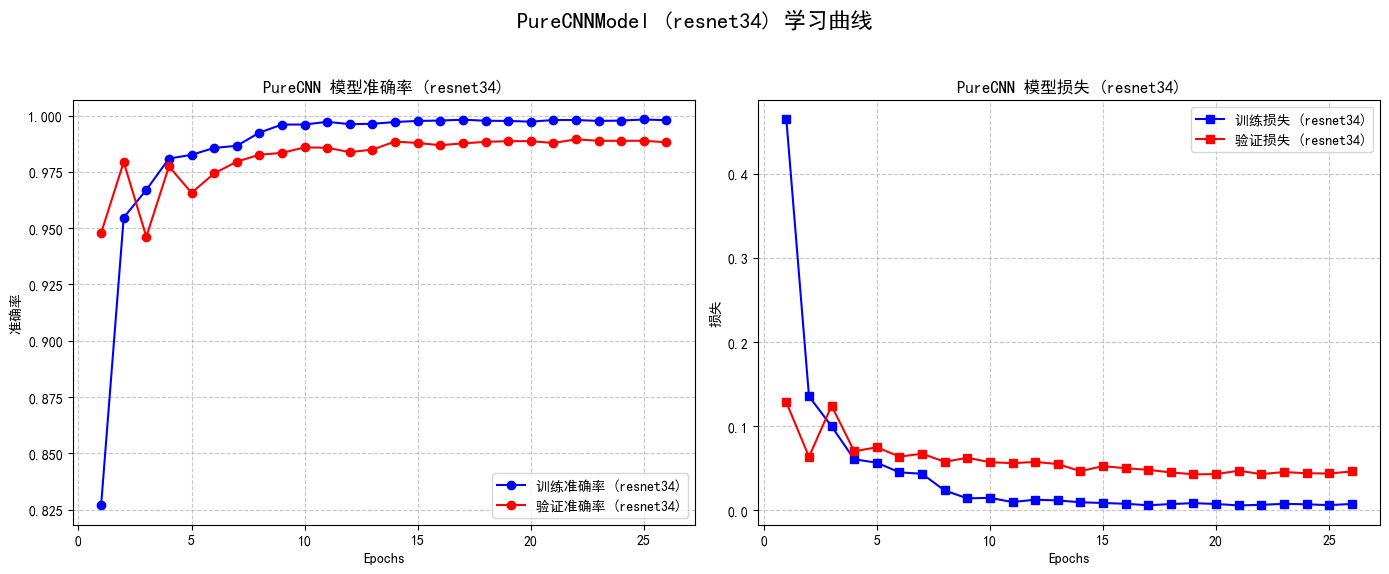


步骤 4: PureCNNModel (resnet34) 训练循环完成。


In [ ]:
# 步骤4: 训练循环 (针对 PureCNNModel, 加入早停逻辑)
import copy 
import json 

print("--- 开始步骤 4 前置检查 (PureCNNModel 训练, 带早停逻辑) ---")
training_can_proceed_cnn = True

# 确保 CHOSEN_MODEL_TYPE 在此步骤中是明确的 (应为 'cnn')
if 'CHOSEN_MODEL_TYPE' not in locals() or CHOSEN_MODEL_TYPE != 'cnn':
    print(f"  [错误] CHOSEN_MODEL_TYPE 未定义或不为 'cnn' (当前值: {locals().get('CHOSEN_MODEL_TYPE', '未定义')})。此步骤专为 PureCNNModel 设计。")
    training_can_proceed_cnn = False

required_vars_for_training_cnn = [
    'model', 'criterion', 'optimizer', 'train_loader', 'val_loader',
    'DEVICE', 'NUM_EPOCHS', 'cnn_backbone_choice' # cnn_backbone_choice 用于保存文件名
]

if training_can_proceed_cnn: # 只有在 CHOSEN_MODEL_TYPE 正确时才继续检查
    for var_name in required_vars_for_training_cnn:
        if var_name in locals() and locals()[var_name] is not None:
            # 特别检查 model 是否为 PureCNNModel 实例
            if var_name == 'model' and not isinstance(model, PureCNNModel):
                print(f"  [错误] 变量 'model' 不是预期的 PureCNNModel 类型 (当前类型: {type(model)})。")
                training_can_proceed_cnn = False
                break
            # print(f"  变量 '{var_name}' 已定义且有效。") # Verbose
        else:
            print(f"  [错误] 必需变量 '{var_name}' 未定义或为 None。")
            training_can_proceed_cnn = False
            break

if training_can_proceed_cnn:
    print(f"\n所有 PureCNNModel ({model.cnn_backbone_name}) 训练组件准备就绪, 开始初始化训练过程 (带早停)...")

    history_cnn = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    best_val_accuracy_cnn = 0.0
    
    # 初始化 best_model_wts_cnn，如果 model 为 None（不应该在此处发生），则后续会出错
    best_model_wts_cnn = copy.deepcopy(model.state_dict()) if model is not None else None
    if model is None:
         print("  [严重警告] model (PureCNNModel) 为 None, 无法初始化 best_model_wts_cnn。训练将失败。")
         training_can_proceed_cnn = False


    early_stopping_patience_cnn = 7  # 连续N个epoch验证损失没有改善则早停
    early_stopping_counter_cnn = 0
    best_val_loss_for_early_stop_cnn = float('inf')
    best_epoch_for_loss_cnn = -1
    min_delta_early_stop_cnn = 0.001 # 验证损失改善的最小阈值

    since_cnn = time.time()
    
    current_backbone_name_for_saving = model.cnn_backbone_name if hasattr(model, 'cnn_backbone_name') else "unknown_cnn"
    SAVE_PATH_CNN_MODEL = f'best_model_cnn_{current_backbone_name_for_saving}.pth'
    HISTORY_SAVE_PATH_CNN = f'training_history_cnn_{current_backbone_name_for_saving}.json'

    print(f"PureCNNModel ({current_backbone_name_for_saving}) 训练开始时间: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(since_cnn))}")
    print(f"  最佳模型将保存到: {SAVE_PATH_CNN_MODEL}")
    print(f"  训练历史将保存到: {HISTORY_SAVE_PATH_CNN}")


    for epoch in range(NUM_EPOCHS):
        if not training_can_proceed_cnn: break # 如果前置检查失败，则跳出

        epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} (模型: PureCNNModel - {current_backbone_name_for_saving})")
        print('-' * 30)

        # 每个 epoch 都有训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 设置模型为训练模式
                dataloader = train_loader
                if dataloader is None:
                    print("  [错误] train_loader (PureCNNModel) 为 None。训练中止。")
                    training_can_proceed_cnn = False; break
                print(f"  训练阶段 (PureCNNModel - {current_backbone_name_for_saving}):")
            else: # phase == 'val'
                model.eval()   # 设置模型为评估模式
                dataloader = val_loader
                if dataloader is None:
                    print("  [警告] val_loader (PureCNNModel) 为 None。验证跳过, 早停可能受影响。")
                    continue # 跳过验证阶段
                print(f"  验证阶段 (PureCNNModel - {current_backbone_name_for_saving}):")

            if dataloader.dataset is None or len(dataloader.dataset) == 0:
                print(f"  [错误] {phase} 阶段的 dataloader 数据集无效/为空。")
                if phase == 'train': training_can_proceed_cnn = False; break
                continue

            running_loss = 0.0
            running_corrects = 0
            dataset_size_phase = len(dataloader.dataset)

            batch_iterator = tqdm(dataloader, desc=f"PureCNN {phase.capitalize()} E{epoch+1}", unit="batch", leave=False)
            for inputs, labels in batch_iterator:
                if inputs.numel() == 0: continue # 跳过空批次 (collate_fn_skip_none 的结果)
                
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad() # 清零梯度

                # 前向传播
                # 只在训练阶段计算梯度
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    #仅在训练阶段进行反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                batch_iterator.set_postfix(loss=f"{loss.item():.4f}", acc=f"{torch.sum(preds == labels.data).item()/inputs.size(0):.2f}")

            if not training_can_proceed_cnn and phase == 'train': break # 如果训练中出错，跳出内外循环

            epoch_loss = running_loss / dataset_size_phase if dataset_size_phase > 0 else float('inf')
            epoch_acc = running_corrects.double() / dataset_size_phase if dataset_size_phase > 0 else 0.0
            
            print(f"    {phase.capitalize()} 损失: {epoch_loss:.4f} 准确率: {epoch_acc:.4f}")

            # 记录损失和准确率
            if phase == 'train':
                history_cnn['train_loss'].append(epoch_loss)
                history_cnn['train_acc'].append(epoch_acc.item() if torch.is_tensor(epoch_acc) else epoch_acc)
            else: # phase == 'val'
                history_cnn['val_loss'].append(epoch_loss)
                history_cnn['val_acc'].append(epoch_acc.item() if torch.is_tensor(epoch_acc) else epoch_acc)
                current_val_loss = epoch_loss

                # 保存最佳模型 (基于验证准确率)
                if epoch_acc > best_val_accuracy_cnn and model is not None and best_model_wts_cnn is not None:
                    best_val_accuracy_cnn = epoch_acc
                    best_model_wts_cnn = copy.deepcopy(model.state_dict())
                    torch.save(best_model_wts_cnn, SAVE_PATH_CNN_MODEL)
                    print(f"      *** 新的最佳 PureCNNModel ({current_backbone_name_for_saving}) (基于准确率: {best_val_accuracy_cnn:.4f}) 已保存到 '{SAVE_PATH_CNN_MODEL}' ***")

                # 早停逻辑 (基于验证损失)
                if current_val_loss < best_val_loss_for_early_stop_cnn - min_delta_early_stop_cnn:
                    best_val_loss_for_early_stop_cnn = current_val_loss
                    best_epoch_for_loss_cnn = epoch
                    early_stopping_counter_cnn = 0
                    print(f"      验证损失改善至 {best_val_loss_for_early_stop_cnn:.4f}, 重置早停计数器。")
                else:
                    early_stopping_counter_cnn += 1
                    print(f"      验证损失未显著改善 ({early_stopping_counter_cnn}/{early_stopping_patience_cnn}) (当前: {current_val_loss:.4f}, 最佳: {best_val_loss_for_early_stop_cnn:.4f})")
        
        # Epoch结束后的操作
        epoch_duration = time.time() - epoch_start_time
        print(f"  Epoch {epoch+1} (PureCNNModel - {current_backbone_name_for_saving}) 完成, 耗时: {epoch_duration // 60:.0f}分 {epoch_duration % 60:.2f}秒")

        if scheduler is not None:
            scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
            print(f"  学习率调度器更新, 当前学习率: {current_lr:.3e}")
        
        if not training_can_proceed_cnn:
            print("训练因错误提前中止。")
            break 
            
        if early_stopping_counter_cnn >= early_stopping_patience_cnn:
            print(f"\n早停触发 (PureCNNModel - {current_backbone_name_for_saving})! 在 Epoch {epoch+1}, 连续 {early_stopping_patience_cnn} 个 Epochs 验证损失未显著改善。")
            print(f"  取得的最佳验证损失为 {best_val_loss_for_early_stop_cnn:.4f} (在 epoch {best_epoch_for_loss_cnn + 1})。")
            break
    
    # 训练循环结束
    if training_can_proceed_cnn:
        time_elapsed_cnn = time.time() - since_cnn
        print(f'\nPureCNNModel ({current_backbone_name_for_saving}) 训练完成 (或早停), 总耗时: {time_elapsed_cnn // 60:.0f}分 {time_elapsed_cnn % 60:.2f}秒')
        print(f'  基于准确率的最佳验证准确率 (PureCNNModel - {current_backbone_name_for_saving}): {best_val_accuracy_cnn:.4f}')
        if early_stopping_counter_cnn >= early_stopping_patience_cnn:
            print(f'  训练因早停而结束。基于损失的最佳验证损失 (PureCNNModel - {current_backbone_name_for_saving}): {best_val_loss_for_early_stop_cnn:.4f} (epoch {best_epoch_for_loss_cnn + 1})')

        # 加载最佳模型权重 (如果模型和权重都存在)
        if model is not None and best_model_wts_cnn is not None and os.path.exists(SAVE_PATH_CNN_MODEL):
            print(f"\n正在加载 PureCNNModel ({current_backbone_name_for_saving}) 基于准确率的最佳权重从 '{SAVE_PATH_CNN_MODEL}'...")
            model.load_state_dict(torch.load(SAVE_PATH_CNN_MODEL)) 
            print("  最佳权重加载成功。")
        elif model is not None:
            print(f"  [警告] 未找到最佳模型权重文件 '{SAVE_PATH_CNN_MODEL}' 或权重未在训练中更新。模型将保持最后状态。")

        # 保存训练历史
        print(f"\n正在保存 PureCNNModel ({current_backbone_name_for_saving}) 的训练历史到 '{HISTORY_SAVE_PATH_CNN}'...")
        history_to_save_cnn = {}
        for key, values in history_cnn.items(): # 将Tensor转为Python数值
            history_to_save_cnn[key] = [v.item() if torch.is_tensor(v) else v for v in values]
        
        with open(HISTORY_SAVE_PATH_CNN, 'w') as f: 
            json.dump(history_to_save_cnn, f, indent=4)
        print(f"  PureCNNModel ({current_backbone_name_for_saving}) 训练历史成功保存。")

        # 绘制学习曲线
        print(f"\n--- 绘制 PureCNNModel ({current_backbone_name_for_saving}) 的学习曲线 ---")
        actual_epochs_trained_cnn = len(history_cnn.get('train_acc', []))
        if actual_epochs_trained_cnn > 0:
            epochs_range_plot_cnn = range(1, actual_epochs_trained_cnn + 1)
            plt.figure(figsize=(14, 6))

            plt.subplot(1, 2, 1)
            plt.plot(epochs_range_plot_cnn, history_cnn['train_acc'], 'bo-', label=f'训练准确率 ({current_backbone_name_for_saving})')
            if history_cnn.get('val_acc'):
                 plt.plot(epochs_range_plot_cnn, history_cnn['val_acc'], 'ro-', label=f'验证准确率 ({current_backbone_name_for_saving})')
            plt.title(f'PureCNN 模型准确率 ({current_backbone_name_for_saving})')
            plt.xlabel('Epochs'); plt.ylabel('准确率'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.7)

            plt.subplot(1, 2, 2)
            plt.plot(epochs_range_plot_cnn, history_cnn['train_loss'], 'bs-', label=f'训练损失 ({current_backbone_name_for_saving})')
            if history_cnn.get('val_loss'):
                plt.plot(epochs_range_plot_cnn, history_cnn['val_loss'], 'rs-', label=f'验证损失 ({current_backbone_name_for_saving})')
            plt.title(f'PureCNN 模型损失 ({current_backbone_name_for_saving})')
            plt.xlabel('Epochs'); plt.ylabel('损失'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.7)
            
            plt.suptitle(f"PureCNNModel ({current_backbone_name_for_saving}) 学习曲线", fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        else:
            print("  未能绘制 PureCNNModel 的学习曲线: 训练历史数据不完整或训练未执行。")
    else: # training_can_proceed_cnn is False
        print(f"\nPureCNNModel ({current_backbone_name_for_saving if 'current_backbone_name_for_saving' in locals() else 'N/A'}) 训练因错误提前中止或未开始。")
else: # 前置检查失败
    print(f"\nPureCNNModel 训练未执行, 前置检查失败。")

print(f"\n步骤 4: PureCNNModel ({current_backbone_name_for_saving if 'current_backbone_name_for_saving' in locals() else cnn_backbone_choice}) 训练循环完成。")

--- 开始步骤 5: PureCNNModel (resnet34) 测试集评估 ---
  将尝试从 'best_model_cnn_resnet34.pth' 加载模型权重。

正在加载最佳 PureCNN 模型 (Backbone: resnet34) 从 'best_model_cnn_resnet34.pth' 用于评估...

开始初始化 PureCNNModel (CNN Backbone: resnet34, 分类头 Dropout: 0.5)...
  成功加载 CNN backbone: resnet34 (使用 features_only=True)
  PureCNN: 从 feature_info (最后一个有效阶段) 获取到通道数: 512
  PureCNN: 分类头前 Dropout 层创建, p=0.5
  PureCNN: 分类头创建: Linear(512, 5)
PureCNNModel 初始化完成。
  最佳 PureCNN 模型 (Backbone: resnet34) 加载成功并已设置为评估模式。

正在测试集上评估 PureCNN 模型 (Backbone: resnet34)...



--- PureCNN 模型 (resnet34) 测试集评估结果 ---
  总体测试准确率 (PureCNN Model - resnet34): 0.9804

  分类报告 (PureCNN Model - resnet34):
              precision    recall  f1-score   support

       Apple     0.9700    0.9738    0.9719      2060
       Grape     1.0000    1.0000    1.0000      1121
        Pear     0.9905    0.9488    0.9692      1212
      Banana     1.0000    1.0000    1.0000       477
      Cherry     0.9622    0.9983    0.9799      1148

    accuracy                         0.9804      6018
   macro avg     0.9846    0.9842    0.9842      6018
weighted avg     0.9806    0.9804    0.9804      6018


  混淆矩阵 (PureCNN Model - resnet34):
[[2006    0    9    0   45]
 [   0 1121    0    0    0]
 [  62    0 1150    0    0]
 [   0    0    0  477    0]
 [   0    0    2    0 1146]]


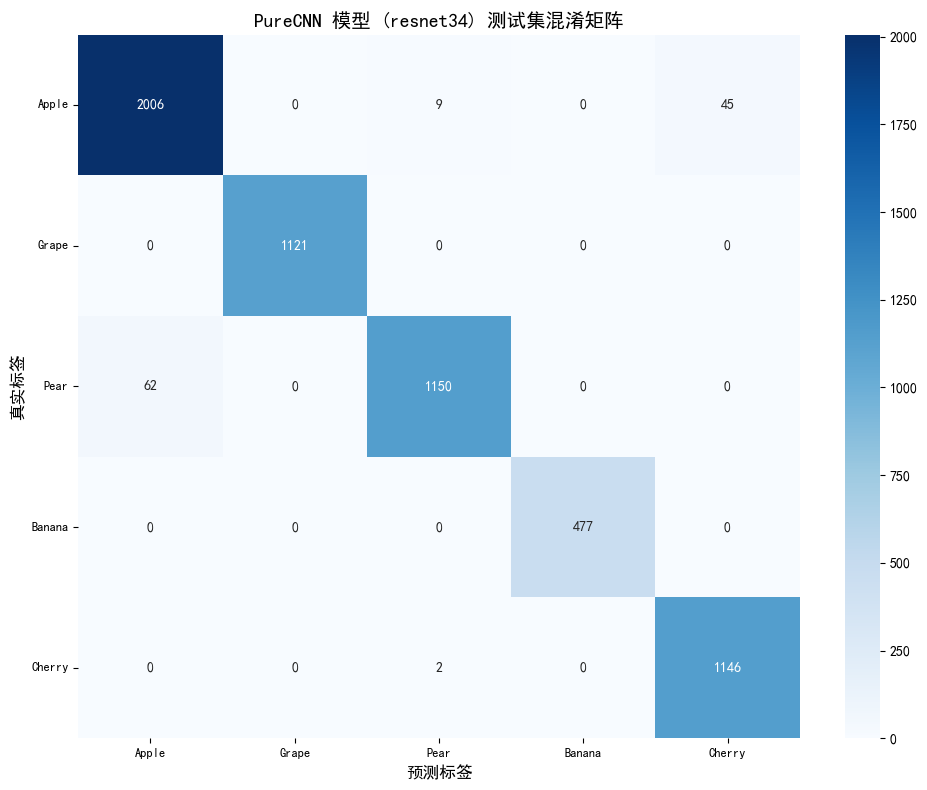

  PureCNN 模型 (resnet34) 混淆矩阵可视化完成。

步骤 5: PureCNNModel (resnet34) 测试集评估完成。


In [ ]:
# 步骤5: 在测试集上评估 PureCNNModel
import seaborn as sns # 用于绘制混淆矩阵
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# cnn_backbone_choice 应从步骤2/4传递过来
# 如果脚本是分块执行，确保 cnn_backbone_choice 在此作用域内有效
current_eval_backbone = cnn_backbone_choice if 'cnn_backbone_choice' in locals() else "unknown_cnn_eval"

print(f"--- 开始步骤 5: PureCNNModel ({current_eval_backbone}) 测试集评估 ---")

# 2. 前置检查和参数准备
evaluation_can_proceed_cnn = True
model_eval_cnn = None # 初始化评估模型

# 评估所需的变量列表
required_vars_s5_cnn = [
    'DEVICE', 'idx_to_class', 'test_loader', 'test_dataset', 'NUM_CLASSES',
    'IMAGE_SIZE', 'PureCNNModel', # 模型类定义
    'cnn_backbone_choice', 'dropout_head_config_cnn', # 与训练时模型配置一致
    'imagenet_mean', 'imagenet_std' # 用于可能的图像逆标准化显示 (如果需要)
]

for var_name in required_vars_s5_cnn:
    if var_name not in locals() or locals()[var_name] is None:
        print(f"  [错误] 评估 PureCNNModel 所需的变量 '{var_name}' 未定义或为 None.")
        evaluation_can_proceed_cnn = False
        break

if 'PureCNNModel' not in globals() and evaluation_can_proceed_cnn:
    print(f"  [错误] 模型类 'PureCNNModel' 未定义。")
    evaluation_can_proceed_cnn = False

if evaluation_can_proceed_cnn and (test_loader is None or test_dataset is None or len(test_dataset) == 0):
    print(f"  [错误] test_loader 或 test_dataset 无效或为空, 无法评估 PureCNNModel。")
    evaluation_can_proceed_cnn = False

# 动态构建模型路径
MODEL_PATH_CNN_EVAL = f'best_model_cnn_{current_eval_backbone}.pth' # 确保与步骤4中保存的名称一致
print(f"  将尝试从 '{MODEL_PATH_CNN_EVAL}' 加载模型权重。")

if evaluation_can_proceed_cnn and not os.path.exists(MODEL_PATH_CNN_EVAL):
    print(f"  [错误] 找不到已保存的最佳 PureCNN 模型文件 '{MODEL_PATH_CNN_EVAL}'。请确保已成功训练并保存模型。")
    evaluation_can_proceed_cnn = False

# 3. 加载最佳 PureCNN 模型
if evaluation_can_proceed_cnn:
    print(f"\n正在加载最佳 PureCNN 模型 (Backbone: {current_eval_backbone}) 从 '{MODEL_PATH_CNN_EVAL}' 用于评估...")
    # 重新实例化 PureCNNModel 结构
    if timm is None:
        print("  [错误] timm 库未加载, 无法实例化基于 timm 的 PureCNNModel。评估中止。")
        evaluation_can_proceed_cnn = False
    
    if evaluation_can_proceed_cnn:
        model_eval_cnn = PureCNNModel( # 使用训练时的配置
            num_classes=NUM_CLASSES,
            cnn_backbone_name=cnn_backbone_choice,
            dropout_classifier_head=dropout_head_config_cnn
        )
        model_eval_cnn.load_state_dict(torch.load(MODEL_PATH_CNN_EVAL, map_location=DEVICE)) # 移除try-except
        model_eval_cnn.to(DEVICE)
        model_eval_cnn.eval() # 设置为评估模式
        print(f"  最佳 PureCNN 模型 (Backbone: {current_eval_backbone}) 加载成功并已设置为评估模式。")

# 4. 在测试集上进行评估
if evaluation_can_proceed_cnn and model_eval_cnn is not None:
    print(f"\n正在测试集上评估 PureCNN 模型 (Backbone: {model_eval_cnn.cnn_backbone_name})...")
    all_labels_cnn = []
    all_preds_cnn = []

    with torch.no_grad(): # 评估时不需要梯度
        test_iterator_cnn_s5 = tqdm(test_loader, desc=f"PureCNN ({model_eval_cnn.cnn_backbone_name}) 测试集评估进度", unit="batch", leave=False)
        for inputs, labels_batch in test_iterator_cnn_s5:
            if inputs.numel() == 0: continue # 跳过空批次
            inputs = inputs.to(DEVICE)
            outputs = model_eval_cnn(inputs)
            _, preds_batch = torch.max(outputs, 1)

            all_labels_cnn.extend(labels_batch.cpu().numpy())
            all_preds_cnn.extend(preds_batch.cpu().numpy())
            # all_probs_cnn.extend(probabilities.cpu().numpy())
            test_iterator_cnn_s5.set_postfix(batch_size=inputs.size(0))

    if not all_labels_cnn or not all_preds_cnn:
        print("  [错误] 未能从 PureCNN 模型收集到任何标签或预测数据。评估中止。")
        evaluation_can_proceed_cnn = False

    # 5. 计算与显示指标
    if evaluation_can_proceed_cnn and all_labels_cnn and all_preds_cnn:
        print(f"\n--- PureCNN 模型 ({model_eval_cnn.cnn_backbone_name}) 测试集评估结果 ---")
        
        target_names_report_cnn = [idx_to_class[i] for i in sorted(idx_to_class.keys())]

        accuracy_cnn = accuracy_score(all_labels_cnn, all_preds_cnn)
        print(f"  总体测试准确率 (PureCNN Model - {model_eval_cnn.cnn_backbone_name}): {accuracy_cnn:.4f}")

        # 分类报告
        report_cnn = classification_report(all_labels_cnn, all_preds_cnn, target_names=target_names_report_cnn, digits=4) # 移除 try-except
        print(f"\n  分类报告 (PureCNN Model - {model_eval_cnn.cnn_backbone_name}):")
        print(report_cnn)

        # 混淆矩阵
        cm_cnn = confusion_matrix(all_labels_cnn, all_preds_cnn)
        print(f"\n  混淆矩阵 (PureCNN Model - {model_eval_cnn.cnn_backbone_name}):")
        print(cm_cnn)

        # 可视化混淆矩阵
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names_report_cnn,
                    yticklabels=target_names_report_cnn,
                    annot_kws={"size": 10})
        plt.xlabel('预测标签', fontsize=12)
        plt.ylabel('真实标签', fontsize=12)
        plt.title(f'PureCNN 模型 ({model_eval_cnn.cnn_backbone_name}) 测试集混淆矩阵', fontsize=14)
        plt.xticks(fontsize=9); plt.yticks(fontsize=9, rotation=0)
        plt.tight_layout(); plt.show()
        print(f"  PureCNN 模型 ({model_eval_cnn.cnn_backbone_name}) 混淆矩阵可视化完成。")
else:
    print(f"\nPureCNN 模型 ({current_eval_backbone}) 评估未执行或未完成, 因为前置检查失败或过程中发生错误。")

print(f"\n步骤 5: PureCNNModel ({current_eval_backbone}) 测试集评估完成。")


--- 开始步骤 6: PureCNNModel (resnet34) 可解释性分析 (Grad-CAM) ---
  信息(步骤6): 使用来自步骤5的 'model_eval_cnn' (PureCNNModel - resnet34) 进行 Grad-CAM。
  Grad-CAM (PureCNN - resnet34) 目标层已选定: layer4[-1].conv2 (Conv2d)
  最终选定的Grad-CAM目标层: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  [信息] 定义局部 denormalize_image_gc_cnn for Grad-CAM.

选择样本并为 PureCNNModel (resnet34) 生成 Grad-CAM 可视化...
  将为 PureCNNModel (resnet34) 生成 Grad-CAM 的样本索引: [1124, 3618, 452, 4676, 1017]

  样本 1124 (264_100.jpg): 真: Apple, PureCNN预: Apple (1.00)
    Captum Grad-CAM (PureCNN - resnet34) 计算成功。


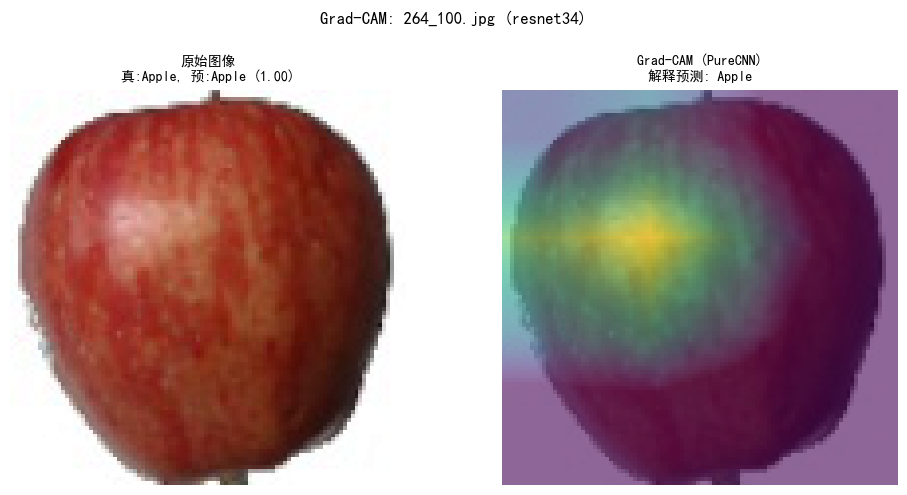


  样本 3618 (r2_265_100.jpg): 真: Pear, PureCNN预: Pear (1.00)
    Captum Grad-CAM (PureCNN - resnet34) 计算成功。


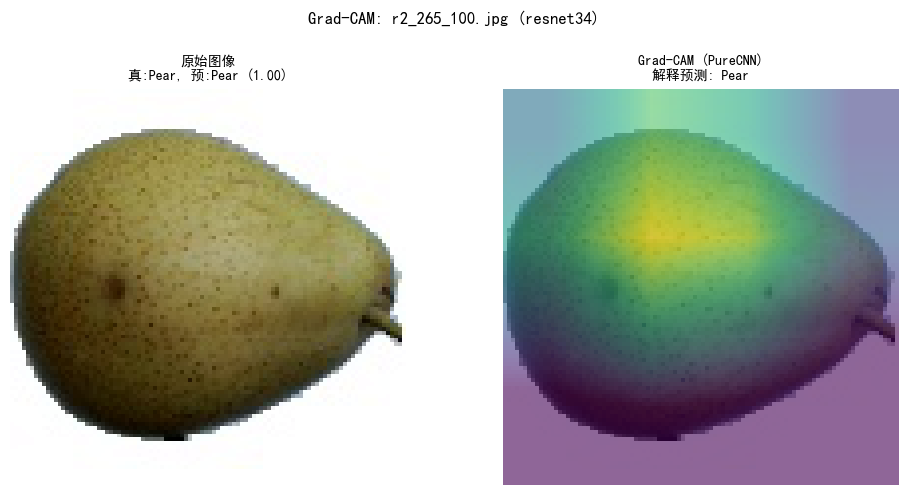


  样本 452 (r_304_100.jpg): 真: Apple, PureCNN预: Apple (1.00)
    Captum Grad-CAM (PureCNN - resnet34) 计算成功。


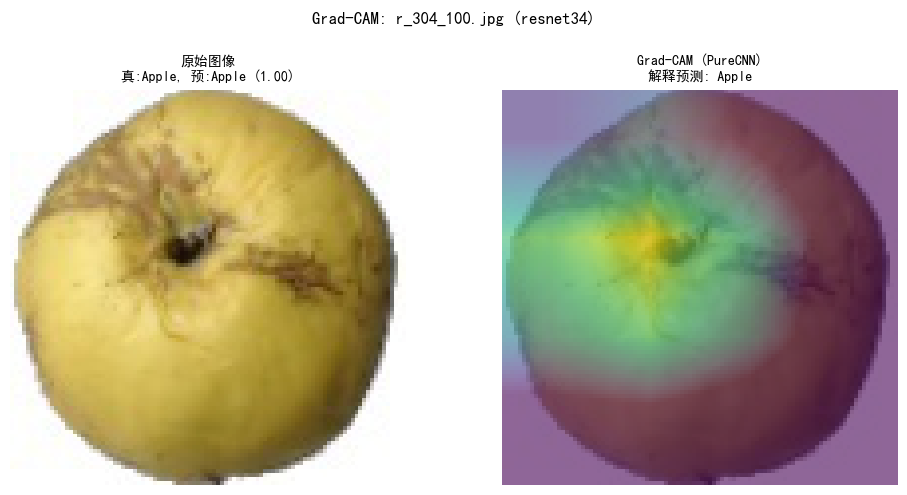


  样本 4676 (r_171_100.jpg): 真: Banana, PureCNN预: Banana (1.00)
    Captum Grad-CAM (PureCNN - resnet34) 计算成功。


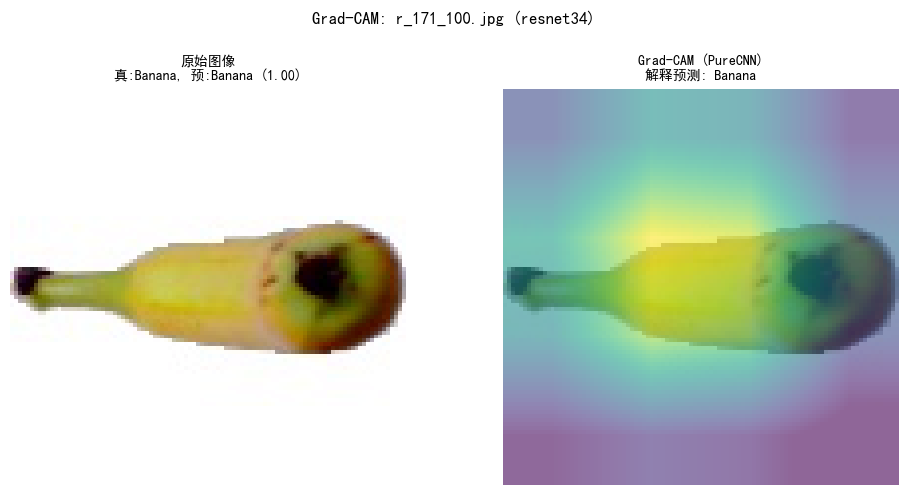


  样本 1017 (291_100.jpg): 真: Apple, PureCNN预: Apple (1.00)
    Captum Grad-CAM (PureCNN - resnet34) 计算成功。


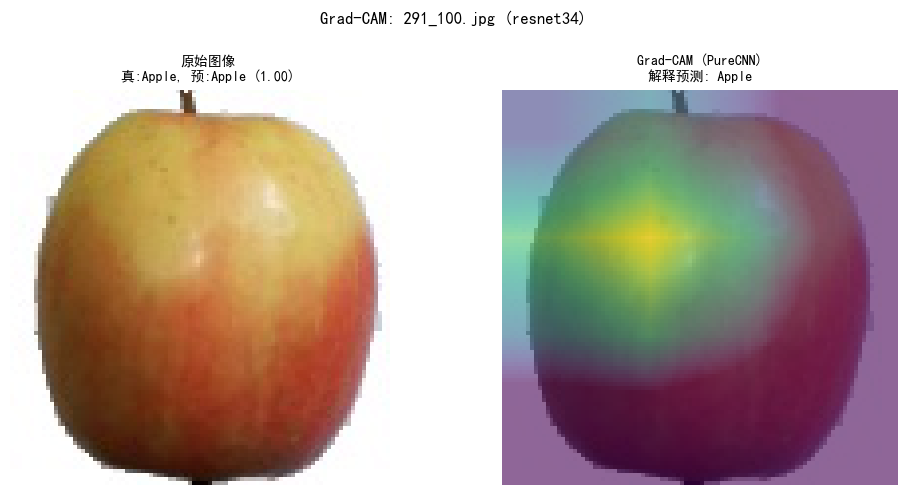


步骤 6: PureCNNModel (resnet34) 可解释性分析 (Grad-CAM) 完成。


In [ ]:
# 步骤 6: PureCNNModel 可解释性分析 (Grad-CAM)
import torch.nn.functional as F # 用于softmax 

# cnn_backbone_choice 应从之前步骤传递
current_gradcam_backbone = cnn_backbone_choice if 'cnn_backbone_choice' in locals() else "unknown_gradcam_cnn"

print(f"\n--- 开始步骤 6: PureCNNModel ({current_gradcam_backbone}) 可解释性分析 (Grad-CAM) ---")

# 2. 前置检查和模型准备
gradcam_can_proceed_cnn = True
model_for_gradcam_cnn = None

# Grad-CAM 所需的变量列表
required_vars_s6_cnn = [
    'DEVICE', 'idx_to_class', 'test_dataset', 'val_test_transforms', # 使用验证/测试变换
    'NUM_CLASSES', 'IMAGE_SIZE', 'PureCNNModel',
    'cnn_backbone_choice', 'dropout_head_config_cnn',
    'imagenet_mean', 'imagenet_std',
    'captum_available', 'LayerGradCam' # Captum 组件
]

for var_name in required_vars_s6_cnn:
    if var_name not in locals() or locals()[var_name] is None:
        print(f"  [错误] Grad-CAM (PureCNN) 所需的变量 '{var_name}' 未定义或为 None.")
        if var_name == 'LayerGradCam' and ('captum_available' in locals() and not captum_available):
             print("          (Captum库或LayerGradCam不可用)")
        gradcam_can_proceed_cnn = False
        break # 发现一个缺失变量就中止

if gradcam_can_proceed_cnn and not captum_available:
    print("  [警告] Captum 库不可用。Grad-CAM 将无法执行。")
    gradcam_can_proceed_cnn = False # 如果Captum强制，则设为False

# 确定用于 Grad-CAM 的 PureCNNModel 实例
if gradcam_can_proceed_cnn:
    model_found_s6_cnn = False
    # 尝试复用步骤5的 model_eval_cnn
    if 'model_eval_cnn' in locals() and model_eval_cnn is not None and \
       isinstance(model_eval_cnn, PureCNNModel) and \
       model_eval_cnn.cnn_backbone_name == current_gradcam_backbone:
        model_for_gradcam_cnn = model_eval_cnn
        print(f"  信息(步骤6): 使用来自步骤5的 'model_eval_cnn' (PureCNNModel - {current_gradcam_backbone}) 进行 Grad-CAM。")
        model_found_s6_cnn = True
    
    # Fallback: 重新加载模型 (与步骤5逻辑类似)
    elif not model_found_s6_cnn:
        MODEL_PATH_GC_S6_CNN = f'best_model_cnn_{current_gradcam_backbone}.pth'
        if os.path.exists(MODEL_PATH_GC_S6_CNN):
            print(f"  信息(步骤6): 未找到合适的现有 PureCNN 模型实例, 尝试重新加载 '{MODEL_PATH_GC_S6_CNN}'...")
            if timm is None:
                print("    [错误] timm 库未加载, 无法实例化模型。Grad-CAM 中止。")
                gradcam_can_proceed_cnn = False
            else:
                model_for_gradcam_cnn = PureCNNModel(NUM_CLASSES, current_gradcam_backbone, dropout_head_config_cnn)
                model_for_gradcam_cnn.load_state_dict(torch.load(MODEL_PATH_GC_S6_CNN, map_location=DEVICE)) # 移除 try-except
                model_for_gradcam_cnn.to(DEVICE)
                model_for_gradcam_cnn.eval()
                print(f"    PureCNN 模型 (Backbone: {current_gradcam_backbone}) 重新加载成功。")
                model_found_s6_cnn = True
        else:
            print(f"  [错误] 无可用 PureCNN 模型实例且 '{MODEL_PATH_GC_S6_CNN}' 不存在。Grad-CAM 中止。")
            gradcam_can_proceed_cnn = False

    if model_for_gradcam_cnn is None and model_found_s6_cnn:
        print(f"  [内部错误] Model found but model_for_gradcam_cnn is None.")
        gradcam_can_proceed_cnn = False


# 3. 选择目标层 (PureCNNModel - ResNet34 特定逻辑)
target_layer_cnn = None
if gradcam_can_proceed_cnn and model_for_gradcam_cnn is not None:
    # 对于 ResNet34 , 在最后一个stage的最后一个block中
    if hasattr(model_for_gradcam_cnn.cnn_backbone, 'layer4'): # ResNet系列通常有layer4
        # layer4 是一个 nn.Sequential of blocks
        # 我们取 layer4 中最后一个 block (e.g., BasicBlock for ResNet18/34)
        last_block_in_layer4 = model_for_gradcam_cnn.cnn_backbone.layer4[-1]
        if hasattr(last_block_in_layer4, 'conv2'): # ResNet BasicBlock 的最后一个卷积
            target_layer_cnn = last_block_in_layer4.conv2
            print(f"  Grad-CAM (PureCNN - {current_gradcam_backbone}) 目标层已选定: layer4[-1].conv2 ({type(target_layer_cnn).__name__})")
        elif hasattr(last_block_in_layer4, 'conv3'): # ResNet Bottleneck 的最后一个卷积
            target_layer_cnn = last_block_in_layer4.conv3
            print(f"  Grad-CAM (PureCNN - {current_gradcam_backbone}) 目标层已选定: layer4[-1].conv3 ({type(target_layer_cnn).__name__})")
        else: # Fallback: 直接用最后一个 block
            target_layer_cnn = last_block_in_layer4 
            print(f"  Grad-CAM (PureCNN - {current_gradcam_backbone}) 目标层已选定 (Fallback): layer4[-1] ({type(target_layer_cnn).__name__})")
    else:
        # 通用 Fallback: 查找 cnn_backbone 中最后一个 Conv2d 层
        found_last_conv = None
        for m in reversed(list(model_for_gradcam_cnn.cnn_backbone.modules())):
            if isinstance(m, nn.Conv2d):
                found_last_conv = m
                break
        if found_last_conv:
            target_layer_cnn = found_last_conv
            print(f"  Grad-CAM (PureCNN - {current_gradcam_backbone}) 目标层已选定 (Ultimate Fallback - last Conv2d found): {type(target_layer_cnn).__name__}")
        else:
            print(f"  [错误] 无法为模型 {current_gradcam_backbone} 自动确定 Grad-CAM 目标层。Grad-CAM 中止。")
            gradcam_can_proceed_cnn = False
            
    if target_layer_cnn is None and gradcam_can_proceed_cnn: # 如果前面逻辑未能设置，则中止
        print("  [错误] 未能自动确定Grad-CAM目标层。")
        gradcam_can_proceed_cnn = False
    elif gradcam_can_proceed_cnn:
         print(f"  最终选定的Grad-CAM目标层: {target_layer_cnn}")


# 5. 定义逆标准化函数 
if gradcam_can_proceed_cnn and 'denormalize_image_gc_cnn' not in globals():
    print("  [信息] 定义局部 denormalize_image_gc_cnn for Grad-CAM.")
    def denormalize_image_gc_cnn(tensor, mean, std): 
        tensor_gc = tensor.clone().cpu().squeeze(0)
        for t_ch, m_val, s_val in zip(tensor_gc, mean, std):
            t_ch.mul_(s_val).add_(m_val)
        return torch.clamp(tensor_gc.permute(1, 2, 0), 0, 1).numpy()

# 6. 选择样本并可视化
if gradcam_can_proceed_cnn and model_for_gradcam_cnn is not None and \
   target_layer_cnn is not None and \
   test_dataset is not None and len(test_dataset) > 0 and \
   captum_available and LayerGradCam is not None: 

    print(f"\n选择样本并为 PureCNNModel ({model_for_gradcam_cnn.cnn_backbone_name}) 生成 Grad-CAM 可视化...")
    
    # 实例化 LayerGradCam
    lgc_cnn = LayerGradCam(model_for_gradcam_cnn, target_layer_cnn)

    num_samples_gradcam_cnn = min(NUM_CLASSES, len(test_dataset) if test_dataset else 0, 5) # 显示5个或类别数个样本
    sample_indices_gradcam_cnn = []
    
    if num_samples_gradcam_cnn > 0:
        # 简化: 随机挑选几个样本
        sample_indices_gradcam_cnn = np.random.choice(len(test_dataset), num_samples_gradcam_cnn, replace=False).tolist()
        print(f"  将为 PureCNNModel ({model_for_gradcam_cnn.cnn_backbone_name}) 生成 Grad-CAM 的样本索引: {sample_indices_gradcam_cnn}")

    for sample_idx in sample_indices_gradcam_cnn:
        img_path, true_label_idx_val = test_dataset.samples[sample_idx]
        true_label_idx = true_label_idx_val.item() if isinstance(true_label_idx_val, torch.Tensor) else true_label_idx_val

        original_pil_img = Image.open(img_path).convert('RGB') 
        input_tensor = val_test_transforms(original_pil_img) # 使用验证/测试集的变换
        input_batch = input_tensor.unsqueeze(0).to(DEVICE)

        # 获取模型预测
        with torch.no_grad():
            outputs = model_for_gradcam_cnn(input_batch)
        probabilities = torch.softmax(outputs, dim=1)
        pred_prob, pred_idx_tensor = torch.max(probabilities, 1)
        pred_idx = pred_idx_tensor.item()

        true_label_name = idx_to_class.get(true_label_idx, "未知")
        pred_label_name = idx_to_class.get(pred_idx, "未知")
        pred_confidence = pred_prob.item()

        print(f"\n  样本 {sample_idx} ({os.path.basename(img_path)}): 真: {true_label_name}, PureCNN预: {pred_label_name} ({pred_confidence:.2f})")

        # 计算 Grad-CAM attribution
        attribution_cnn = lgc_cnn.attribute(input_batch, target=pred_idx) # 目标为预测类别
        
        # 将 attribution 上采样到图像尺寸 
        if hasattr(LayerAttribution, 'interpolate'):
            heatmap_tensor_resized_cnn = LayerAttribution.interpolate(attribution_cnn, (IMAGE_SIZE, IMAGE_SIZE), interpolate_mode='bilinear')
        else: # 简单平均或手动resize (旧版Captum可能需要)
            heatmap_tensor_resized_cnn = F.interpolate(attribution_cnn, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

        heatmap_np_raw_cnn = heatmap_tensor_resized_cnn.squeeze().cpu().detach().numpy()

        # 处理热力图 
        if heatmap_np_raw_cnn.ndim == 3: # (C, H, W) -> (H, W)
            heatmap_np_raw_cnn = heatmap_np_raw_cnn.mean(axis=0) if heatmap_np_raw_cnn.shape[0] < heatmap_np_raw_cnn.shape[-1] else heatmap_np_raw_cnn.mean(axis=-1)
        
        heatmap_np_cnn = np.maximum(heatmap_np_raw_cnn, 0) # ReLU
        if np.max(heatmap_np_cnn) > 1e-9: # 归一化 (避免除以0)
            heatmap_np_cnn = heatmap_np_cnn / np.max(heatmap_np_cnn)
        else:
            heatmap_np_cnn = np.zeros_like(heatmap_np_cnn)
        print(f"    Captum Grad-CAM (PureCNN - {model_for_gradcam_cnn.cnn_backbone_name}) 计算成功。")

        # 可视化
        display_image_np_cnn = denormalize_image_gc_cnn(input_tensor, imagenet_mean, imagenet_std)
        
        fig_gc_cnn, axs_gc_cnn = plt.subplots(1, 2, figsize=(10, 5))
        axs_gc_cnn[0].imshow(display_image_np_cnn)
        axs_gc_cnn[0].set_title(f"原始图像\n真:{true_label_name}, 预:{pred_label_name} ({pred_confidence:.2f})", fontsize=10)
        axs_gc_cnn[0].axis('off')

        axs_gc_cnn[1].imshow(display_image_np_cnn)
        if heatmap_np_cnn is not None and heatmap_np_cnn.size > 0:
            axs_gc_cnn[1].imshow(heatmap_np_cnn, cmap='viridis', alpha=0.6)
        axs_gc_cnn[1].set_title(f"Grad-CAM (PureCNN)\n解释预测: {pred_label_name}", fontsize=10)
        axs_gc_cnn[1].axis('off')
        
        plt.suptitle(f"Grad-CAM: {os.path.basename(img_path)} ({model_for_gradcam_cnn.cnn_backbone_name})", fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

    if not sample_indices_gradcam_cnn:
         print(f"  没有可供 PureCNNModel ({current_gradcam_backbone}) 可视化的样本索引, 或相关组件未准备好。")
elif gradcam_can_proceed_cnn : # 表示某些组件 (model, target_layer, dataset, captum) 未准备好
    print(f"  PureCNNModel ({current_gradcam_backbone}) Grad-CAM 未执行, 相关组件未完全准备好。")
else: # gradcam_can_proceed_cnn is False
    print(f"\nPureCNNModel ({current_gradcam_backbone}) Grad-CAM 分析未执行, 因为前置检查失败。")

print(f"\n步骤 6: PureCNNModel ({current_gradcam_backbone}) 可解释性分析 (Grad-CAM) 完成。")


--- 开始步骤 7: 使用 PureCNNModel (resnet34) 测试新拍摄的真实图片 ---
  信息(步骤7): 使用来自步骤6的 'model_for_gradcam_cnn' (resnet34)。
  信息(步骤7): 尝试配置Grad-CAM...
    Grad-CAM 工具已为目标层 Conv2d 初始化。

准备测试图片路径 (PureCNN)...
  信息: 从 './my_test_images_for_step7' 找到 5 张图片。

将对 5 张新图片进行预测 (PureCNN Model - resnet34) 和 Grad-CAM (如果可用):

--- 处理图片: 0000.jpg (PureCNN) ---
    >>> PureCNN (resnet34) 模型预测: 'Cherry' (置信度: 99.97%)
    正在为 PureCNN (resnet34) 生成 Grad-CAM...
      Captum Grad-CAM (PureCNN) 计算成功。


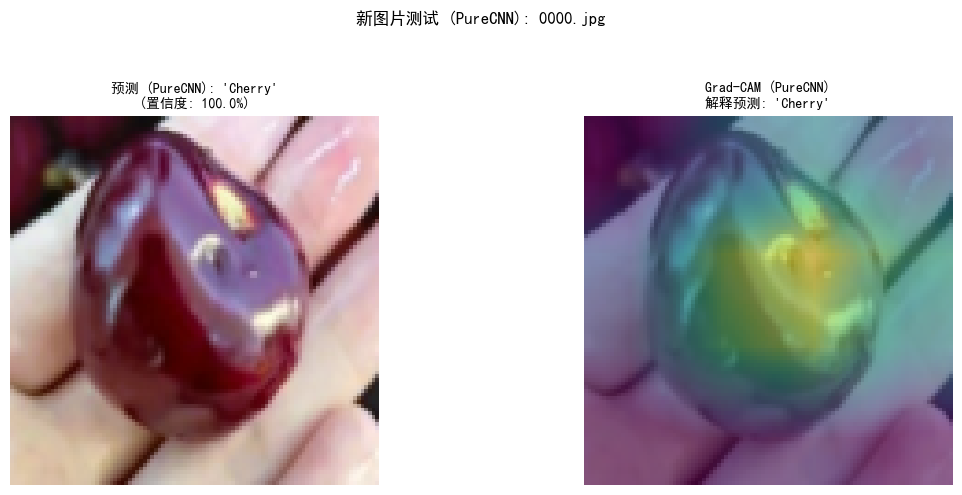


--- 处理图片: banana2.jpg (PureCNN) ---
    >>> PureCNN (resnet34) 模型预测: 'Banana' (置信度: 99.99%)
    正在为 PureCNN (resnet34) 生成 Grad-CAM...
      Captum Grad-CAM (PureCNN) 计算成功。


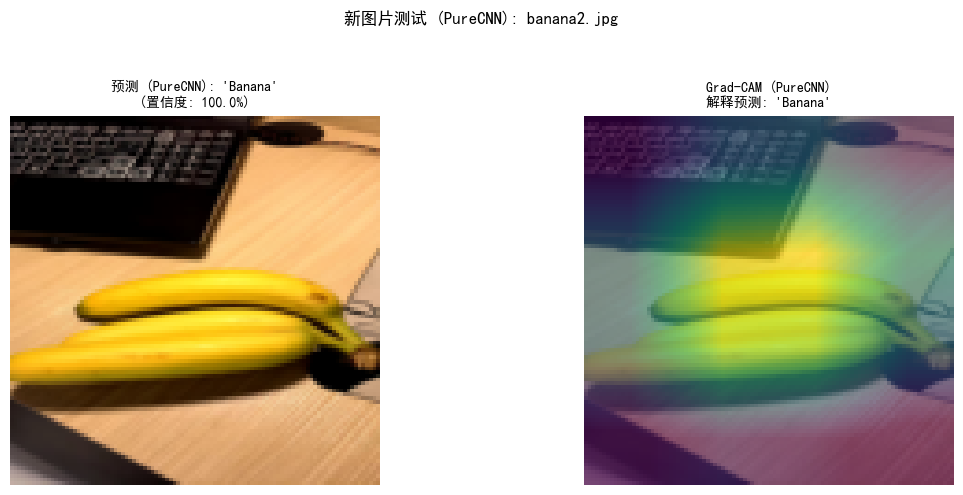


--- 处理图片: c9857422cad5b6f4c759789f7c71bd2.jpg (PureCNN) ---
    >>> PureCNN (resnet34) 模型预测: 'Grape' (置信度: 90.64%)
    正在为 PureCNN (resnet34) 生成 Grad-CAM...
      Captum Grad-CAM (PureCNN) 计算成功。


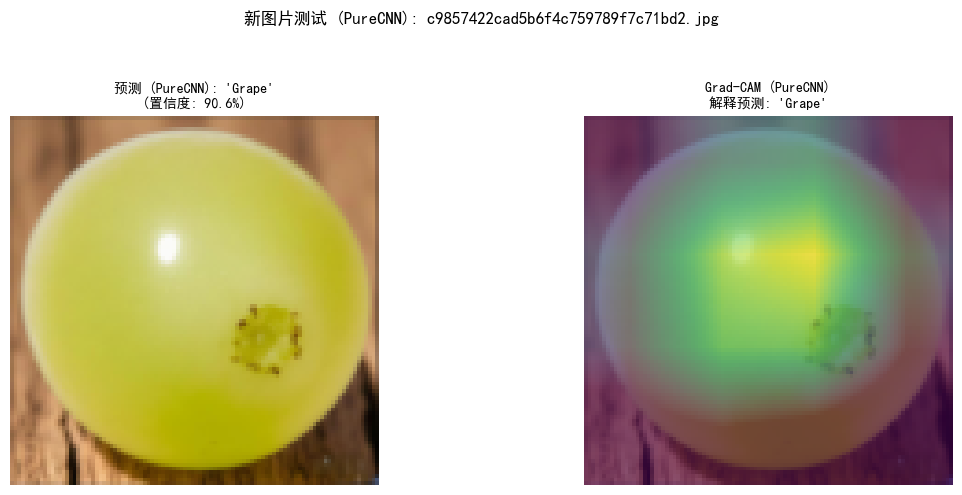


--- 处理图片: fa9e6adb994f810dbc24426739873a9.jpg (PureCNN) ---
    >>> PureCNN (resnet34) 模型预测: 'Pear' (置信度: 75.79%)
    正在为 PureCNN (resnet34) 生成 Grad-CAM...
      Captum Grad-CAM (PureCNN) 计算成功。


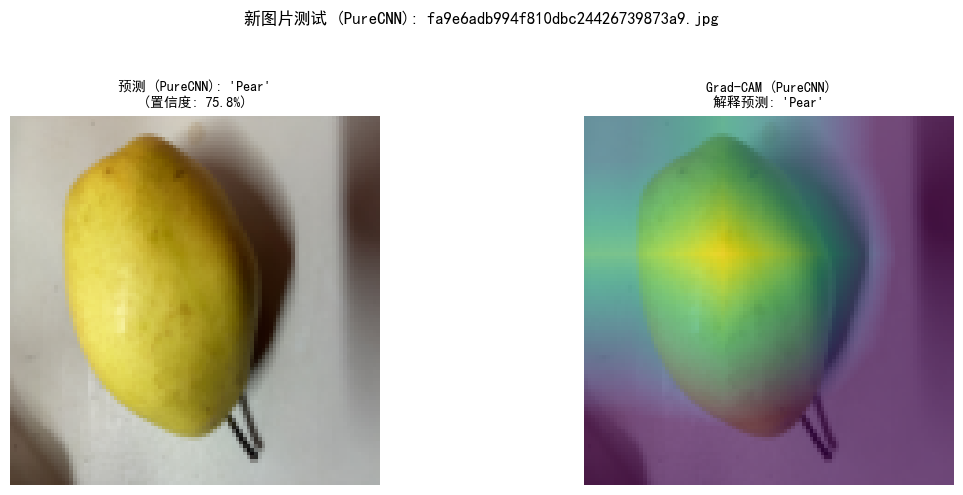


--- 处理图片: ffb08d218761f20500963b824f701d0.jpg (PureCNN) ---
    >>> PureCNN (resnet34) 模型预测: 'Apple' (置信度: 99.04%)
    正在为 PureCNN (resnet34) 生成 Grad-CAM...
      Captum Grad-CAM (PureCNN) 计算成功。


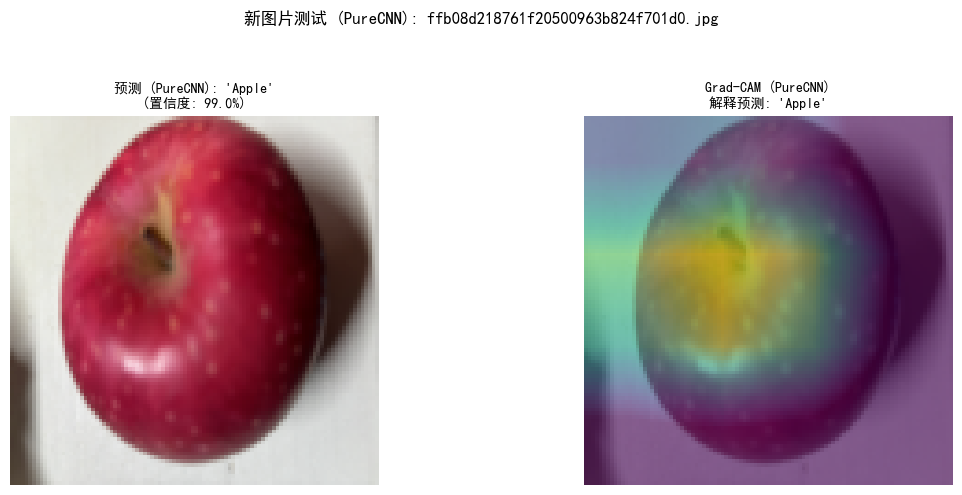


步骤 7: 使用 PureCNNModel (resnet34) 测试新拍摄的真实图片完成。


In [ ]:
# 步骤 7: 使用 PureCNNModel 测试新拍摄的真实图片 (带 Grad-CAM)

current_s7_backbone = cnn_backbone_choice if 'cnn_backbone_choice' in locals() else "unknown_s7_cnn"

print(f"\n--- 开始步骤 7: 使用 PureCNNModel ({current_s7_backbone}) 测试新拍摄的真实图片 ---")

# 1. 前置检查和模型准备
testing_can_proceed_s7_cnn = True
eval_model_s7_cnn = None # 此步骤使用的模型实例

required_vars_s7_cnn = [
    'DEVICE', 'idx_to_class', 'val_test_transforms', 'IMAGE_SIZE',
    'NUM_CLASSES', 'PureCNNModel', 'cnn_backbone_choice',
    'dropout_head_config_cnn', 'imagenet_mean', 'imagenet_std',
    'captum_available', 'LayerGradCam' # Grad-CAM 相关
]
for var_name in required_vars_s7_cnn:
    if var_name not in locals() or locals()[var_name] is None:
        print(f"  [错误](步骤7): 必需变量 '{var_name}' (PureCNN) 未定义或为 None.")
        if var_name == 'LayerGradCam' and ('captum_available' in locals() and not captum_available):
             print("            (Captum库或LayerGradCam不可用, Grad-CAM将无法进行)")
        testing_can_proceed_s7_cnn = False
        break

if 'PureCNNModel' not in globals() and testing_can_proceed_s7_cnn:
    print(f"  [错误](步骤7): 模型类 'PureCNNModel' 未定义。")
    testing_can_proceed_s7_cnn = False

# 确定模型实例 (应为已训练的 PureCNNModel with cnn_backbone_choice)
if testing_can_proceed_s7_cnn:
    model_found_s7_cnn = False
    # 尝试复用步骤6的 model_for_gradcam_cnn 或步骤5的 model_eval_cnn
    if 'model_for_gradcam_cnn' in locals() and model_for_gradcam_cnn is not None and \
       isinstance(model_for_gradcam_cnn, PureCNNModel) and \
       model_for_gradcam_cnn.cnn_backbone_name == current_s7_backbone:
        eval_model_s7_cnn = model_for_gradcam_cnn
        print(f"  信息(步骤7): 使用来自步骤6的 'model_for_gradcam_cnn' ({current_s7_backbone})。")
        model_found_s7_cnn = True
    elif 'model_eval_cnn' in locals() and model_eval_cnn is not None and \
         isinstance(model_eval_cnn, PureCNNModel) and \
         model_eval_cnn.cnn_backbone_name == current_s7_backbone:
        eval_model_s7_cnn = model_eval_cnn
        print(f"  信息(步骤7): 使用来自步骤5的 'model_eval_cnn' ({current_s7_backbone})。")
        model_found_s7_cnn = True
    
    if not model_found_s7_cnn: # Fallback: 重新加载模型
        MODEL_PATH_S7_CNN = f'best_model_cnn_{current_s7_backbone}.pth'
        if os.path.exists(MODEL_PATH_S7_CNN):
            print(f"  信息(步骤7): 未找到合适实例, 尝试从 '{MODEL_PATH_S7_CNN}' 加载模型...")
            if timm is None:
                print("    [错误] timm 库未加载, 无法实例化模型。")
                testing_can_proceed_s7_cnn = False
            else:
                eval_model_s7_cnn = PureCNNModel(NUM_CLASSES, current_s7_backbone, dropout_head_config_cnn)
                eval_model_s7_cnn.load_state_dict(torch.load(MODEL_PATH_S7_CNN, map_location=DEVICE)) 
                eval_model_s7_cnn.to(DEVICE)
                eval_model_s7_cnn.eval() # 确保是评估模式
                print(f"    PureCNN 模型 ({current_s7_backbone}) 重新加载成功。")
                model_found_s7_cnn = True # 虽然加载了，但标记一下
        else:
            print(f"  [错误](步骤7): 找不到模型文件 '{MODEL_PATH_S7_CNN}'。无法进行测试。")
            testing_can_proceed_s7_cnn = False
    
    if eval_model_s7_cnn is not None:
        eval_model_s7_cnn.eval() # 再次确保是评估模式
    else: # 如果模型最终还是None
        if testing_can_proceed_s7_cnn: # 如果到这里还是True，说明逻辑有问题
             print(f"  [内部错误](步骤7): 模型应已加载或复用，但 eval_model_s7_cnn 仍为 None。")
        testing_can_proceed_s7_cnn = False


# Grad-CAM specific: target layer and tool
grad_cam_tool_s7_cnn = None
target_layer_s7_for_cnn = None # 初始化
if testing_can_proceed_s7_cnn and captum_available and LayerGradCam is not None and eval_model_s7_cnn is not None:
    print("  信息(步骤7): 尝试配置Grad-CAM...")
    # 复用步骤6的目标层选择逻辑 (简化版)
    if hasattr(eval_model_s7_cnn.cnn_backbone, 'layer4') and \
       hasattr(eval_model_s7_cnn.cnn_backbone.layer4[-1], 'conv2'):
        target_layer_s7_for_cnn = eval_model_s7_cnn.cnn_backbone.layer4[-1].conv2
    elif hasattr(model_for_gradcam_cnn.cnn_backbone, 'layer4'): # ResNet系列通常有layer4
        last_block_in_layer4 = model_for_gradcam_cnn.cnn_backbone.layer4[-1]
        if hasattr(last_block_in_layer4, 'conv2'): 
            target_layer_s7_for_cnn = last_block_in_layer4.conv2
        elif hasattr(last_block_in_layer4, 'conv3'): 
            target_layer_s7_for_cnn = last_block_in_layer4.conv3
        else: target_layer_s7_for_cnn = last_block_in_layer4 

    if target_layer_s7_for_cnn:
        grad_cam_tool_s7_cnn = LayerGradCam(eval_model_s7_cnn, target_layer_s7_for_cnn)
        print(f"    Grad-CAM 工具已为目标层 {type(target_layer_s7_for_cnn).__name__} 初始化。")
    else:
        print("    [警告](步骤7): 未能确定Grad-CAM目标层。Grad-CAM将不可用。")
elif testing_can_proceed_s7_cnn : # Captum 或 LayerGradCam 不可用
    print("  信息(步骤7): Captum或LayerGradCam不可用, Grad-CAM将无法进行。")


# 准备新图片路径
new_image_paths_s7_cnn = []
if testing_can_proceed_s7_cnn:
    print("\n准备测试图片路径 (PureCNN)...")
    # 此处定义 image_folder_s7 的路径
    image_folder_s7 = r"./my_test_images_for_step7" # 需要创建此文件夹并放入图片
    
    if not os.path.exists(image_folder_s7) or not os.path.isdir(image_folder_s7):
        print(f"  警告: 指定的图片文件夹 '{image_folder_s7}' 不存在或不是目录。")
        if 'test_dataset' in locals() and test_dataset and len(test_dataset.samples) > 0:
            print("         将使用测试集中的一张随机图片作为示例。")
            sample_img_path_s7, _ = test_dataset.samples[np.random.randint(len(test_dataset.samples))]
            if os.path.exists(sample_img_path_s7):
                new_image_paths_s7_cnn.append(sample_img_path_s7)
            else:
                print(f"         [错误] 测试集示例图片路径 '{sample_img_path_s7}' 无效。测试中止。")
                testing_can_proceed_s7_cnn = False
        else:
            print("         无备选图片。测试中止。")
            testing_can_proceed_s7_cnn = False
    else: # 文件夹存在
        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.webp')
        for filename in os.listdir(image_folder_s7):
            if filename.lower().endswith(image_extensions):
                new_image_paths_s7_cnn.append(os.path.join(image_folder_s7, filename))
        
        if new_image_paths_s7_cnn:
            print(f"  信息: 从 '{image_folder_s7}' 找到 {len(new_image_paths_s7_cnn)} 张图片。")
            # print(f"  图片列表: {new_image_paths_s7_cnn}")
        else:
            print(f"  警告: 文件夹 '{image_folder_s7}' 为空或无支持的图片格式。测试中止。")
            testing_can_proceed_s7_cnn = False


# 定义逆标准化函数 
if testing_can_proceed_s7_cnn and 'denormalize_image_s7_cnn' not in globals():
    if 'denormalize_image_gc_cnn' in globals(): # 复用步骤6的
        denormalize_image_s7_cnn = denormalize_image_gc_cnn
        print("  信息(步骤7): 复用步骤6的 denormalize_image_gc_cnn。")
    else: # 定义局部
        print("  信息(步骤7): 定义局部 denormalize_image_s7_cnn。")
        def denormalize_image_s7_cnn(tensor, mean, std):
            tensor_clone = tensor.clone().cpu().squeeze(0)
            for t_ch, m_val, s_val in zip(tensor_clone, mean, std):
                t_ch.mul_(s_val).add_(m_val)
            return torch.clamp(tensor_clone.permute(1, 2, 0), 0, 1).numpy()

# 循环处理图片
if testing_can_proceed_s7_cnn and new_image_paths_s7_cnn and eval_model_s7_cnn is not None:
    print(f"\n将对 {len(new_image_paths_s7_cnn)} 张新图片进行预测 (PureCNN Model - {eval_model_s7_cnn.cnn_backbone_name}) 和 Grad-CAM (如果可用):")
    for image_path in new_image_paths_s7_cnn:
        print(f"\n--- 处理图片: {os.path.basename(image_path)} (PureCNN) ---")
        if not os.path.exists(image_path): # 双重检查
            print(f"    错误: 图片文件 '{image_path}' 不存在。跳过。")
            continue
        
        pil_img = Image.open(image_path).convert('RGB') 
        input_tensor_s7 = val_test_transforms(pil_img) # 使用验证/测试集的变换
        input_batch_s7 = input_tensor_s7.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            outputs_s7 = eval_model_s7_cnn(input_batch_s7)
        probabilities_s7 = torch.softmax(outputs_s7, dim=1)
        pred_conf_s7, pred_idx_s7_tensor = torch.max(probabilities_s7, 1)
        pred_idx_s7 = pred_idx_s7_tensor.item()
        pred_label_s7 = idx_to_class.get(pred_idx_s7, f"未知索引({pred_idx_s7})")
        confidence_s7 = pred_conf_s7.item()
        print(f"    >>> PureCNN ({eval_model_s7_cnn.cnn_backbone_name}) 模型预测: '{pred_label_s7}' (置信度: {confidence_s7*100:.2f}%)")

        # Grad-CAM 可视化
        heatmap_np_s7_cnn = None
        if grad_cam_tool_s7_cnn is not None and target_layer_s7_for_cnn is not None:
            print(f"    正在为 PureCNN ({eval_model_s7_cnn.cnn_backbone_name}) 生成 Grad-CAM...")
            attribution_s7 = grad_cam_tool_s7_cnn.attribute(input_batch_s7, target=pred_idx_s7) 
            
            if hasattr(LayerAttribution, 'interpolate'):
                heatmap_tensor_resized_s7 = LayerAttribution.interpolate(attribution_s7, (IMAGE_SIZE, IMAGE_SIZE), interpolate_mode='bilinear')
            else:
                heatmap_tensor_resized_s7 = F.interpolate(attribution_s7, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

            heatmap_np_raw_s7 = heatmap_tensor_resized_s7.squeeze().cpu().detach().numpy()
            if heatmap_np_raw_s7.ndim == 3:
                heatmap_np_raw_s7 = heatmap_np_raw_s7.mean(axis=0) if heatmap_np_raw_s7.shape[0] < heatmap_np_raw_s7.shape[-1] else heatmap_np_raw_s7.mean(axis=-1)
            
            heatmap_np_s7_cnn = np.maximum(heatmap_np_raw_s7, 0)
            if np.max(heatmap_np_s7_cnn) > 1e-9: heatmap_np_s7_cnn /= np.max(heatmap_np_s7_cnn)
            else: heatmap_np_s7_cnn = np.zeros_like(heatmap_np_s7_cnn)
            print(f"      Captum Grad-CAM (PureCNN) 计算成功。")
        
        # 显示图像和 Grad-CAM
        display_img_np_s7 = denormalize_image_s7_cnn(input_tensor_s7, imagenet_mean, imagenet_std)
        num_plots_s7 = 2 if heatmap_np_s7_cnn is not None and heatmap_np_s7_cnn.size > 0 else 1
        
        fig_s7, axs_s7 = plt.subplots(1, num_plots_s7, figsize=(6 * num_plots_s7, 5))
        if num_plots_s7 == 1: axs_s7 = [axs_s7] # 确保 axs_s7 是可迭代的

        axs_s7[0].imshow(display_img_np_s7)
        axs_s7[0].set_title(f"预测 (PureCNN): '{pred_label_s7}'\n(置信度: {confidence_s7*100:.1f}%)", fontsize=10)
        axs_s7[0].axis('off')

        if num_plots_s7 == 2:
            axs_s7[1].imshow(display_img_np_s7)
            axs_s7[1].imshow(heatmap_np_s7_cnn, cmap='viridis', alpha=0.6)
            axs_s7[1].set_title(f"Grad-CAM (PureCNN)\n解释预测: '{pred_label_s7}'", fontsize=10)
            axs_s7[1].axis('off')
        
        fig_s7.suptitle(f"新图片测试 (PureCNN): {os.path.basename(image_path)}", fontsize=12)
        plt.tight_layout(rect=[0, 0, 1, 0.93 if num_plots_s7 > 1 else 0.95])
        plt.show()

elif testing_can_proceed_s7_cnn:
    print("\n(PureCNN) 无新图片可测试或模型未准备好。")
else:
    print(f"\n(PureCNN) ({current_s7_backbone}) 新图片测试未执行, 因为前置检查失败。")

print(f"\n步骤 7: 使用 PureCNNModel ({current_s7_backbone}) 测试新拍摄的真实图片完成。")